In [1]:
import pandas as pd
import math
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats.stats import pearsonr
import seaborn as sn

In [2]:
df = pd.read_csv('dataset/matches_datacleaning.csv', index_col = 0)
pd.set_option('display.max_columns', None) # to visualize all the columns
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 185750 entries, 0 to 185749
Data columns (total 49 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   tourney_id          185750 non-null  object 
 1   tourney_name        185750 non-null  object 
 2   surface             185588 non-null  object 
 3   draw_size           185750 non-null  float64
 4   tourney_level       185750 non-null  object 
 5   tourney_date        185750 non-null  object 
 6   match_num           185750 non-null  float64
 7   winner_id           185750 non-null  float64
 8   winner_name         185750 non-null  object 
 9   winner_hand         185750 non-null  object 
 10  winner_ioc          185750 non-null  object 
 11  loser_id            185750 non-null  float64
 12  loser_name          185750 non-null  object 
 13  loser_hand          185750 non-null  object 
 14  loser_ioc           185750 non-null  object 
 15  score               185581 non-nul

C:\Users\Gerlando\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
df['tourney_date'] = pd.to_datetime(df['tourney_date'])
df['tourney_year'] = df['tourney_date'].dt.year

### functions

In [4]:
def create_new_colums(winner_attr, loser_attr, attr):
    col1=df[['winner_name',winner_attr]].copy()
    col2=df[['loser_name',loser_attr]].copy()
    col2.rename(columns={'loser_name': 'winner_name'}, inplace = True)
    col2.rename(columns={loser_attr: winner_attr}, inplace = True)
    name2 = col1.append(col2) 
    name2.rename(columns={'winner_name': 'name',winner_attr:attr}, inplace = True)
    name2.drop_duplicates(inplace=True)
    return name2


In [5]:
def create_df(series):
    tmp = pd.DataFrame(series)
    tmp.reset_index(inplace=True)
    return tmp

def count_occ(df, attr_to_count):
    tmp = df[attr_to_count].value_counts(dropna=False)
    tmp = create_df(tmp)
    return tmp

## Dataframe with Players profile

#### matches' number per player

To discover if a player's name is an outlier we must count the name's occurences both in winner_name and loser_name, if its occurrences are very low then we consider it as an outlier. We assume this, also because if we have few statistics about a player then we don't have the sufficient known about him to costruct an exaustive profile.

In [6]:
#matches won per player
num_matches_won = count_occ(df, 'winner_name')
num_matches_won.set_axis(['name', 'num_matches'], axis=1, inplace=True)

#matches loss per player
num_matches_loss = count_occ(df, 'loser_name')
num_matches_loss.set_axis(['name', 'num_matches'], axis=1, inplace=True)

#total matches per player
num_matches = num_matches_won.append(num_matches_loss)
num_matches = num_matches.groupby(['name']).num_matches.sum()
num_matches = create_df(num_matches)
num_matches.set_axis(['name', 'num_matches'], axis=1, inplace=True)

#drop players with few matches
num_matches = num_matches[num_matches['num_matches'] > 10]

#add ratio
num_matches_won.set_axis(['name', 'num_matches_won'], axis=1, inplace=True) #rename attribute 'num_matches' to 'num_matches_won', otherwise we could have a conflict
num_matches = pd.merge(num_matches, num_matches_won, how = 'left', on = 'name')
num_matches['ratio'] = num_matches['num_matches_won']/num_matches['num_matches']
num_matches.fillna(0, inplace = True)

del num_matches['num_matches_won'] #reduntant column

#RENAME our database
player_profile = num_matches
player_profile

,name,num_matches,ratio
0,AARON ADDISON,11,0.181818
1,ABBIE MYERS,157,0.477707
2,ABHINAV SANJEEV SHANMUGAM,16,0.500000
3,ABIGAIL DESIATNIKOV,12,0.583333
4,ABIGAIL TERE APISAH,126,0.587302
...,...,...,...
3902,ZOI MEERS,26,0.038462
3903,ZORA HUDSON,27,0.222222
3904,ZOZIYA KARDAVA,78,0.410256
3905,ZSOMBOR PIROS,86,0.546512


## Statistics of players during period

In [7]:
years=df['tourney_year'].dropna()
years=years.unique()
years.sort()

for year in years:
    num_matches_year = df[df['tourney_year']==year] #takes only matches of a year
    num_m_y = 'num_matches_'+str(year)
    
    #matches won per player
    num_matches_won = count_occ(num_matches_year, 'winner_name')
    num_matches_won.set_axis(['name', num_m_y], axis=1, inplace=True)
    
    #matches loss per player
    num_matches_loss = count_occ(num_matches_year, 'loser_name')
    num_matches_loss.set_axis(['name', num_m_y], axis=1, inplace=True)
    
    #total matches per player
    num_matches = num_matches_won.append(num_matches_loss)
    num_matches = num_matches.groupby(['name'])[num_m_y].sum()
    num_matches = create_df(num_matches)
    num_matches.set_axis(['name', num_m_y], axis=1, inplace=True)
    
    #add ratio
    num_matches_won.set_axis(['name', 'num_matches_won_'+str(year)], axis=1, inplace=True) #rename attribute 'num_matches' to 'num_matches_won', otherwise we could have a conflict
    num_matches = pd.merge(num_matches, num_matches_won, how = 'left', on = 'name')
    #num_matches['ratio_'+str(year)] = num_matches['num_matches_won']/num_matches[num_m_y]
    num_matches.fillna(0, inplace = True)
    #del num_matches['num_matches_won']
    
    #add to our player profile ratio and matches of current year
    player_profile = pd.merge(player_profile, num_matches, how = 'left', on = 'name')
    player_profile.fillna(0, inplace = True) #players with no matches during a year

player_profile['num_matches_2016-2019']=player_profile['num_matches_2016']+player_profile['num_matches_2017']+player_profile['num_matches_2018']+player_profile['num_matches_2019']
del player_profile['num_matches_2016']
del player_profile['num_matches_2017']
del player_profile['num_matches_2018']
del player_profile['num_matches_2019']
player_profile['ratio_2016-2019']=player_profile['num_matches_won_2016']+player_profile['num_matches_won_2017']+player_profile['num_matches_won_2018']+player_profile['num_matches_won_2019']
player_profile['ratio_2016-2019']=player_profile['ratio_2016-2019']/player_profile['num_matches_2016-2019']
del player_profile['num_matches_won_2016']
del player_profile['num_matches_won_2017']
del player_profile['num_matches_won_2018']
del player_profile['num_matches_won_2019']

player_profile['num_matches_2020-2021']=player_profile['num_matches_2020']+player_profile['num_matches_2021']
del player_profile['num_matches_2020']
del player_profile['num_matches_2021']

player_profile['ratio_2020-2021']=player_profile['num_matches_won_2020']+player_profile['num_matches_won_2021']
player_profile['ratio_2020-2021']=player_profile['ratio_2020-2021']/player_profile['num_matches_2020-2021']
del player_profile['num_matches_won_2020']
del player_profile['num_matches_won_2021']

player_profile
    

,name,num_matches,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021
0,AARON ADDISON,11,0.181818,10.0,0.200000,1.0,0.000000
1,ABBIE MYERS,157,0.477707,142.0,0.478873,15.0,0.466667
2,ABHINAV SANJEEV SHANMUGAM,16,0.500000,13.0,0.461538,3.0,0.666667
3,ABIGAIL DESIATNIKOV,12,0.583333,12.0,0.583333,0.0,NaN
4,ABIGAIL TERE APISAH,126,0.587302,113.0,0.575221,13.0,0.692308
...,...,...,...,...,...,...,...
3902,ZOI MEERS,26,0.038462,22.0,0.000000,4.0,0.250000
3903,ZORA HUDSON,27,0.222222,13.0,0.307692,14.0,0.142857
3904,ZOZIYA KARDAVA,78,0.410256,40.0,0.475000,38.0,0.342105
3905,ZSOMBOR PIROS,86,0.546512,83.0,0.542169,3.0,0.666667


## Player's Hand

In [8]:
df_hand=create_new_colums('winner_hand','loser_hand','hand')
#df_hand.at[180480, 'hand'] = 'R'#AGGIUSTARE QUESTA COSA
df_hand.drop_duplicates(inplace=True)

player_profile=pd.merge(player_profile, df_hand, how='left', on='name')
player_profile

,name,num_matches,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,hand
0,AARON ADDISON,11,0.181818,10.0,0.200000,1.0,0.000000,R
1,ABBIE MYERS,157,0.477707,142.0,0.478873,15.0,0.466667,R
2,ABHINAV SANJEEV SHANMUGAM,16,0.500000,13.0,0.461538,3.0,0.666667,U
3,ABIGAIL DESIATNIKOV,12,0.583333,12.0,0.583333,0.0,NaN,R
4,ABIGAIL TERE APISAH,126,0.587302,113.0,0.575221,13.0,0.692308,U
...,...,...,...,...,...,...,...,...
3902,ZOI MEERS,26,0.038462,22.0,0.000000,4.0,0.250000,U
3903,ZORA HUDSON,27,0.222222,13.0,0.307692,14.0,0.142857,U
3904,ZOZIYA KARDAVA,78,0.410256,40.0,0.475000,38.0,0.342105,U
3905,ZSOMBOR PIROS,86,0.546512,83.0,0.542169,3.0,0.666667,R


## Player's Gender

In [9]:
df_gender = create_new_colums('winner_gender','loser_gender','gender')
player_profile = pd.merge(player_profile, df_gender, how='left', on='name')
player_profile

,name,num_matches,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,hand,gender
0,AARON ADDISON,11,0.181818,10.0,0.200000,1.0,0.000000,R,M
1,ABBIE MYERS,157,0.477707,142.0,0.478873,15.0,0.466667,R,F
2,ABHINAV SANJEEV SHANMUGAM,16,0.500000,13.0,0.461538,3.0,0.666667,U,M
3,ABIGAIL DESIATNIKOV,12,0.583333,12.0,0.583333,0.0,NaN,R,F
4,ABIGAIL TERE APISAH,126,0.587302,113.0,0.575221,13.0,0.692308,U,F
...,...,...,...,...,...,...,...,...,...
3902,ZOI MEERS,26,0.038462,22.0,0.000000,4.0,0.250000,U,F
3903,ZORA HUDSON,27,0.222222,13.0,0.307692,14.0,0.142857,U,F
3904,ZOZIYA KARDAVA,78,0.410256,40.0,0.475000,38.0,0.342105,U,F
3905,ZSOMBOR PIROS,86,0.546512,83.0,0.542169,3.0,0.666667,R,M


## Player's nationality

In [10]:
df_ioc = create_new_colums('winner_ioc','loser_ioc','ioc')
df_ioc.drop_duplicates(inplace=True)

player_profile = pd.merge(player_profile, df_ioc, how='left', on='name')
player_profile

,name,num_matches,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,hand,gender,ioc
0,AARON ADDISON,11,0.181818,10.0,0.200000,1.0,0.000000,R,M,AUS
1,ABBIE MYERS,157,0.477707,142.0,0.478873,15.0,0.466667,R,F,AUS
2,ABHINAV SANJEEV SHANMUGAM,16,0.500000,13.0,0.461538,3.0,0.666667,U,M,IND
3,ABIGAIL DESIATNIKOV,12,0.583333,12.0,0.583333,0.0,NaN,R,F,USA
4,ABIGAIL TERE APISAH,126,0.587302,113.0,0.575221,13.0,0.692308,U,F,PNG
...,...,...,...,...,...,...,...,...,...,...
3902,ZOI MEERS,26,0.038462,22.0,0.000000,4.0,0.250000,U,F,BEL
3903,ZORA HUDSON,27,0.222222,13.0,0.307692,14.0,0.142857,U,F,USA
3904,ZOZIYA KARDAVA,78,0.410256,40.0,0.475000,38.0,0.342105,U,F,RUS
3905,ZSOMBOR PIROS,86,0.546512,83.0,0.542169,3.0,0.666667,R,M,HUN


## ages of players 

In [11]:
#winner_bith
winner_birth=df.groupby(['winner_name']).winner_birth.min() #print(gg.groupby(['winner_name']).birth.min())
winner_birth = create_df(winner_birth)
winner_birth.set_axis(['name', 'birth'], axis=1, inplace=True)

#loser_birth
loser_birth = df.groupby(['loser_name']).loser_birth.min() #print(gg.groupby(['loser_name']).birth.min())
loser_birth = create_df(loser_birth)
loser_birth.set_axis(['name', 'birth'], axis=1, inplace=True)

#players_birth
name_birth = winner_birth.append(loser_birth)
name_birth.dropna(inplace=True)
name_birth.drop_duplicates(inplace=True)
name_birth = name_birth.groupby(name_birth['name']).birth.min()
name_birth = create_df(name_birth)

player_profile = pd.merge(player_profile, name_birth, how='left', on='name')
player_profile

,name,num_matches,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,hand,gender,ioc,birth
0,AARON ADDISON,11,0.181818,10.0,0.200000,1.0,0.000000,R,M,AUS,1996.0
1,ABBIE MYERS,157,0.477707,142.0,0.478873,15.0,0.466667,R,F,AUS,1994.0
2,ABHINAV SANJEEV SHANMUGAM,16,0.500000,13.0,0.461538,3.0,0.666667,U,M,IND,1998.0
3,ABIGAIL DESIATNIKOV,12,0.583333,12.0,0.583333,0.0,NaN,R,F,USA,2001.0
4,ABIGAIL TERE APISAH,126,0.587302,113.0,0.575221,13.0,0.692308,U,F,PNG,1992.0
...,...,...,...,...,...,...,...,...,...,...,...
3902,ZOI MEERS,26,0.038462,22.0,0.000000,4.0,0.250000,U,F,BEL,2001.0
3903,ZORA HUDSON,27,0.222222,13.0,0.307692,14.0,0.142857,U,F,USA,NaN
3904,ZOZIYA KARDAVA,78,0.410256,40.0,0.475000,38.0,0.342105,U,F,RUS,2001.0
3905,ZSOMBOR PIROS,86,0.546512,83.0,0.542169,3.0,0.666667,R,M,HUN,1999.0


## height of players

In [12]:
df_ht=create_new_colums('winner_ht','loser_ht','ht')
df_ht.dropna(inplace=True)
df_ht.drop_duplicates(inplace=True)
df_ht = df_ht.groupby(['name']).ht.max() 

player_profile=pd.merge(player_profile, df_ht, how='left', on='name')
player_profile

#completare aggiungendo l'altezza media tramite le nazionalità dei giocatori

,name,num_matches,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,hand,gender,ioc,birth,ht
0,AARON ADDISON,11,0.181818,10.0,0.200000,1.0,0.000000,R,M,AUS,1996.0,187.076923
1,ABBIE MYERS,157,0.477707,142.0,0.478873,15.0,0.466667,R,F,AUS,1994.0,170.857143
2,ABHINAV SANJEEV SHANMUGAM,16,0.500000,13.0,0.461538,3.0,0.666667,U,M,IND,1998.0,183.800000
3,ABIGAIL DESIATNIKOV,12,0.583333,12.0,0.583333,0.0,NaN,R,F,USA,2001.0,173.181818
4,ABIGAIL TERE APISAH,126,0.587302,113.0,0.575221,13.0,0.692308,U,F,PNG,1992.0,172.137868
...,...,...,...,...,...,...,...,...,...,...,...,...
3902,ZOI MEERS,26,0.038462,22.0,0.000000,4.0,0.250000,U,F,BEL,2001.0,174.800000
3903,ZORA HUDSON,27,0.222222,13.0,0.307692,14.0,0.142857,U,F,USA,NaN,173.181818
3904,ZOZIYA KARDAVA,78,0.410256,40.0,0.475000,38.0,0.342105,U,F,RUS,2001.0,165.312500
3905,ZSOMBOR PIROS,86,0.546512,83.0,0.542169,3.0,0.666667,R,M,HUN,1999.0,184.000000


### Minutes

In [13]:
#mean winner minutes
win_min =df.groupby('winner_name').minutes.mean()
win_min = create_df(win_min)
win_min.set_axis(['name', 'minutes'], axis=1, inplace=True)

#mean loser minutes
loser_min = df.groupby('loser_name').minutes.mean()
loser_min = create_df(loser_min)
loser_min.set_axis(['name', 'minutes'], axis=1, inplace=True)

#mean player minutes
player_min = win_min.append(loser_min)
player_min = player_min.groupby('name').minutes.mean()

#add to player profile
player_profile = pd.merge(player_profile, player_min, how='left', on='name')
player_profile

,name,num_matches,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,hand,gender,ioc,birth,ht,minutes
0,AARON ADDISON,11,0.181818,10.0,0.200000,1.0,0.000000,R,M,AUS,1996.0,187.076923,86.694444
1,ABBIE MYERS,157,0.477707,142.0,0.478873,15.0,0.466667,R,F,AUS,1994.0,170.857143,61.621951
2,ABHINAV SANJEEV SHANMUGAM,16,0.500000,13.0,0.461538,3.0,0.666667,U,M,IND,1998.0,183.800000,86.875000
3,ABIGAIL DESIATNIKOV,12,0.583333,12.0,0.583333,0.0,NaN,R,F,USA,2001.0,173.181818,60.000000
4,ABIGAIL TERE APISAH,126,0.587302,113.0,0.575221,13.0,0.692308,U,F,PNG,1992.0,172.137868,63.205561
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3902,ZOI MEERS,26,0.038462,22.0,0.000000,4.0,0.250000,U,F,BEL,2001.0,174.800000,60.000000
3903,ZORA HUDSON,27,0.222222,13.0,0.307692,14.0,0.142857,U,F,USA,NaN,173.181818,60.000000
3904,ZOZIYA KARDAVA,78,0.410256,40.0,0.475000,38.0,0.342105,U,F,RUS,2001.0,165.312500,60.000000
3905,ZSOMBOR PIROS,86,0.546512,83.0,0.542169,3.0,0.666667,R,M,HUN,1999.0,184.000000,101.407801


###### rapport ace/svpt 

è il rapporto tra gli ace fatti e il numero di "battute" effettuate durante un match

svpt = numero di battute totali = numero di prime battute (1stIN) + numero di seconde battute (secondo tentativo se sbagli il primo, questo attributo non viene fornito ma è ricavabile)

### Percentage ace

fare la percetuale rispetto a tutti i servizi fatti oppure rispetto solo al primo servizio? la prof consiglia rispetto al primo servizio. Online dicono che un ace al secondo servizio è raro

In [14]:
#table tot ace per player 
win_ace =df.groupby('winner_name').w_ace.sum()
win_ace = create_df(win_ace)
win_ace.set_axis(['name', 'ace'], axis=1, inplace=True)

loser_ace =df.groupby('loser_name').l_ace.sum()
loser_ace = create_df(loser_ace)
loser_ace.set_axis(['name', 'ace'], axis=1, inplace=True)

player_ace = win_ace.append(loser_ace)
player_ace = player_ace.groupby('name').ace.sum()

#table tot 1stIn per player
win_1stIn =df.groupby('winner_name').w_1stIn.sum()
win_1stIn= create_df(win_1stIn)
win_1stIn.set_axis(['name', 'p_1stIn'], axis=1, inplace=True)

loser_1stIn =df.groupby('loser_name').l_1stIn.sum()
loser_1stIn = create_df(loser_1stIn)
loser_1stIn.set_axis(['name', 'p_1stIn'], axis=1, inplace=True)

player_1stIn= win_1stIn.append(loser_1stIn)
player_1stIn = player_1stIn.groupby('name').p_1stIn.sum()


p = pd.merge(player_ace, player_1stIn, how = 'left', on = 'name')
p['perc_ace'] = round((p['ace'] / p['p_1stIn'])*100, 2)
del p['ace']
del p['p_1stIn']
player_profile = pd.merge(player_profile, p, how = 'left', on = 'name')
player_profile

,name,num_matches,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,hand,gender,ioc,birth,ht,minutes,perc_ace
0,AARON ADDISON,11,0.181818,10.0,0.200000,1.0,0.000000,R,M,AUS,1996.0,187.076923,86.694444,14.98
1,ABBIE MYERS,157,0.477707,142.0,0.478873,15.0,0.466667,R,F,AUS,1994.0,170.857143,61.621951,1.30
2,ABHINAV SANJEEV SHANMUGAM,16,0.500000,13.0,0.461538,3.0,0.666667,U,M,IND,1998.0,183.800000,86.875000,20.59
3,ABIGAIL DESIATNIKOV,12,0.583333,12.0,0.583333,0.0,NaN,R,F,USA,2001.0,173.181818,60.000000,0.00
4,ABIGAIL TERE APISAH,126,0.587302,113.0,0.575221,13.0,0.692308,U,F,PNG,1992.0,172.137868,63.205561,3.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3902,ZOI MEERS,26,0.038462,22.0,0.000000,4.0,0.250000,U,F,BEL,2001.0,174.800000,60.000000,0.00
3903,ZORA HUDSON,27,0.222222,13.0,0.307692,14.0,0.142857,U,F,USA,NaN,173.181818,60.000000,0.00
3904,ZOZIYA KARDAVA,78,0.410256,40.0,0.475000,38.0,0.342105,U,F,RUS,2001.0,165.312500,60.000000,0.00
3905,ZSOMBOR PIROS,86,0.546512,83.0,0.542169,3.0,0.666667,R,M,HUN,1999.0,184.000000,101.407801,7.13


In [15]:
win_1stwon =df.groupby('winner_name').w_1stWon.sum()
win_1stwon = create_df(win_1stwon)
win_1stwon.set_axis(['name', 'p_1stwon'], axis=1, inplace=True)

loser_1stwon =df.groupby('loser_name').l_1stWon.sum()
loser_1stwon = create_df(loser_1stwon)
loser_1stwon.set_axis(['name', 'p_1stwon'], axis=1, inplace=True)

player_1stwon= win_1stwon.append(loser_1stwon)
player_1stwon = player_1stwon.groupby('name').p_1stwon.sum()

p = pd.merge(player_1stIn, player_1stwon, how = 'left', on = 'name')
p['_1stwon_1stIn'] = (p['p_1stwon'] / p['p_1stIn']) *100
del p['p_1stwon']
del p['p_1stIn']
player_profile = pd.merge(player_profile, p, how = 'left', on = 'name')
player_profile

,name,num_matches,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,hand,gender,ioc,birth,ht,minutes,perc_ace,_1stwon_1stIn
0,AARON ADDISON,11,0.181818,10.0,0.200000,1.0,0.000000,R,M,AUS,1996.0,187.076923,86.694444,14.98,68.357488
1,ABBIE MYERS,157,0.477707,142.0,0.478873,15.0,0.466667,R,F,AUS,1994.0,170.857143,61.621951,1.30,29.801525
2,ABHINAV SANJEEV SHANMUGAM,16,0.500000,13.0,0.461538,3.0,0.666667,U,M,IND,1998.0,183.800000,86.875000,20.59,71.881188
3,ABIGAIL DESIATNIKOV,12,0.583333,12.0,0.583333,0.0,NaN,R,F,USA,2001.0,173.181818,60.000000,0.00,0.000000
4,ABIGAIL TERE APISAH,126,0.587302,113.0,0.575221,13.0,0.692308,U,F,PNG,1992.0,172.137868,63.205561,3.32,57.931157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3902,ZOI MEERS,26,0.038462,22.0,0.000000,4.0,0.250000,U,F,BEL,2001.0,174.800000,60.000000,0.00,0.000000
3903,ZORA HUDSON,27,0.222222,13.0,0.307692,14.0,0.142857,U,F,USA,NaN,173.181818,60.000000,0.00,0.000000
3904,ZOZIYA KARDAVA,78,0.410256,40.0,0.475000,38.0,0.342105,U,F,RUS,2001.0,165.312500,60.000000,0.00,0.000000
3905,ZSOMBOR PIROS,86,0.546512,83.0,0.542169,3.0,0.666667,R,M,HUN,1999.0,184.000000,101.407801,7.13,64.704364


#### total_won_service / total_service

In [16]:
#total service
win_svpt =df.groupby('winner_name').w_svpt.sum()
win_svpt = create_df(win_svpt)
win_svpt.set_axis(['name', 'svpt'], axis=1, inplace=True)

loser_svpt =df.groupby('loser_name').l_svpt.sum()
loser_svpt = create_df(loser_svpt)
loser_svpt.set_axis(['name', 'svpt'], axis=1, inplace=True)

player_svpt= win_svpt.append(loser_svpt)
player_svpt = player_svpt.groupby('name').svpt.sum()

player_svpt

name
AADA INNA                 74.0
AALISHA ALEXIS           112.0
AALIYA EBRAHIM           581.0
AALIYAH HOHMANN          168.0
AALYKA EBRAHIM           260.0
                        ...   
ZUZANA ZALABSKA          217.0
ZUZANA ZLOCHOVA        14041.0
ZUZANNA BEDNARZ          130.0
ZUZANNA SZCZEPANSKA      181.0
ZVONIMIR ORESKOVIC        34.0
Name: svpt, Length: 10103, dtype: float64

In [17]:
#winner second service won
win_2ndwon =df.groupby('winner_name').w_2ndWon.sum()
win_2ndwon = create_df(win_2ndwon)
win_2ndwon.set_axis(['name', 'p_2ndwon'], axis=1, inplace=True)

#loser second service won
loser_2ndwon =df.groupby('loser_name').l_2ndWon.sum()
loser_2ndwon = create_df(loser_2ndwon)
loser_2ndwon.set_axis(['name', 'p_2ndwon'], axis=1, inplace=True)

#player second service won
player_2ndwon= win_2ndwon.append(loser_2ndwon)
player_2ndwon = player_2ndwon.groupby('name').p_2ndwon.sum()

player_2ndwon

name
AADA INNA                 0.0
AALISHA ALEXIS            0.0
AALIYA EBRAHIM            0.0
AALIYAH HOHMANN           0.0
AALYKA EBRAHIM            0.0
                        ...  
ZUZANA ZALABSKA           0.0
ZUZANA ZLOCHOVA        1746.0
ZUZANNA BEDNARZ           0.0
ZUZANNA SZCZEPANSKA       0.0
ZVONIMIR ORESKOVIC        3.0
Name: p_2ndwon, Length: 10103, dtype: float64

In [18]:
#total number of service won (1st won + 2nd won)
total_serv_won = pd.merge(player_1stwon, player_2ndwon, how = 'left', on = 'name')
total_serv_won['total_won'] = total_serv_won['p_1stwon'] + total_serv_won['p_2ndwon']
total_serv_won.drop(['p_1stwon', 'p_2ndwon'], axis=1, inplace=True)

#calculate ratio: total_serv_won / total_serve
tot = pd.merge(total_serv_won, player_svpt, how = 'left', on = 'name')
tot['serv_won_tot_seve'] = tot['total_won'] / tot['svpt']
tot.drop(['total_won', 'svpt'], axis=1, inplace=True)

player_profile = pd.merge(player_profile, tot, how = 'left', on = 'name')
player_profile

,name,num_matches,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,hand,gender,ioc,birth,ht,minutes,perc_ace,_1stwon_1stIn,serv_won_tot_seve
0,AARON ADDISON,11,0.181818,10.0,0.200000,1.0,0.000000,R,M,AUS,1996.0,187.076923,86.694444,14.98,68.357488,0.587855
1,ABBIE MYERS,157,0.477707,142.0,0.478873,15.0,0.466667,R,F,AUS,1994.0,170.857143,61.621951,1.30,29.801525,0.270003
2,ABHINAV SANJEEV SHANMUGAM,16,0.500000,13.0,0.461538,3.0,0.666667,U,M,IND,1998.0,183.800000,86.875000,20.59,71.881188,0.613701
3,ABIGAIL DESIATNIKOV,12,0.583333,12.0,0.583333,0.0,NaN,R,F,USA,2001.0,173.181818,60.000000,0.00,0.000000,0.000000
4,ABIGAIL TERE APISAH,126,0.587302,113.0,0.575221,13.0,0.692308,U,F,PNG,1992.0,172.137868,63.205561,3.32,57.931157,0.565383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3902,ZOI MEERS,26,0.038462,22.0,0.000000,4.0,0.250000,U,F,BEL,2001.0,174.800000,60.000000,0.00,0.000000,0.000000
3903,ZORA HUDSON,27,0.222222,13.0,0.307692,14.0,0.142857,U,F,USA,NaN,173.181818,60.000000,0.00,0.000000,0.000000
3904,ZOZIYA KARDAVA,78,0.410256,40.0,0.475000,38.0,0.342105,U,F,RUS,2001.0,165.312500,60.000000,0.00,0.000000,0.000000
3905,ZSOMBOR PIROS,86,0.546512,83.0,0.542169,3.0,0.666667,R,M,HUN,1999.0,184.000000,101.407801,7.13,64.704364,0.584936


### breakpoints
total number of breakpoints for each player

In [19]:
def sum_col(df, gb_attr, attr_to_count, n_gb_attr, n_attr_to_count):
    player =df.groupby(gb_attr)[attr_to_count].sum()
    player = create_df(player)
    player.set_axis([n_gb_attr, n_attr_to_count], axis=1, inplace=True)
    return player


In [20]:
#breakpoints faced
win_bpfaced = sum_col(df, 'winner_name', 'w_bpFaced', 'name', 'bpFaced')
loser_bpfaced = sum_col(df, 'loser_name', 'l_bpFaced', 'name', 'bpFaced')
player_bpfaced = win_bpfaced.append(loser_bpfaced)
player_bpfaced = player_bpfaced.groupby('name').bpFaced.sum()

player_profile = pd.merge(player_profile, player_bpfaced, how = 'left', on = 'name')

#breakpoints saved
win_bpsaved = sum_col(df, 'winner_name', 'w_bpSaved', 'name', 'bpsaved')
loser_bpsaved = sum_col(df, 'loser_name', 'l_bpSaved', 'name', 'bpsaved')
player_bpsaved = win_bpsaved.append(loser_bpsaved)
player_bpsaved = player_bpsaved.groupby('name').bpsaved.sum()

player_profile = pd.merge(player_profile, player_bpsaved, how = 'left', on = 'name')

player_profile

,name,num_matches,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,hand,gender,ioc,birth,ht,minutes,perc_ace,_1stwon_1stIn,serv_won_tot_seve,bpFaced,bpsaved
0,AARON ADDISON,11,0.181818,10.0,0.200000,1.0,0.000000,R,M,AUS,1996.0,187.076923,86.694444,14.98,68.357488,0.587855,83.0,52.0
1,ABBIE MYERS,157,0.477707,142.0,0.478873,15.0,0.466667,R,F,AUS,1994.0,170.857143,61.621951,1.30,29.801525,0.270003,819.0,255.0
2,ABHINAV SANJEEV SHANMUGAM,16,0.500000,13.0,0.461538,3.0,0.666667,U,M,IND,1998.0,183.800000,86.875000,20.59,71.881188,0.613701,111.0,67.0
3,ABIGAIL DESIATNIKOV,12,0.583333,12.0,0.583333,0.0,NaN,R,F,USA,2001.0,173.181818,60.000000,0.00,0.000000,0.000000,0.0,0.0
4,ABIGAIL TERE APISAH,126,0.587302,113.0,0.575221,13.0,0.692308,U,F,PNG,1992.0,172.137868,63.205561,3.32,57.931157,0.565383,1081.0,618.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3902,ZOI MEERS,26,0.038462,22.0,0.000000,4.0,0.250000,U,F,BEL,2001.0,174.800000,60.000000,0.00,0.000000,0.000000,0.0,0.0
3903,ZORA HUDSON,27,0.222222,13.0,0.307692,14.0,0.142857,U,F,USA,NaN,173.181818,60.000000,0.00,0.000000,0.000000,0.0,0.0
3904,ZOZIYA KARDAVA,78,0.410256,40.0,0.475000,38.0,0.342105,U,F,RUS,2001.0,165.312500,60.000000,0.00,0.000000,0.000000,0.0,0.0
3905,ZSOMBOR PIROS,86,0.546512,83.0,0.542169,3.0,0.666667,R,M,HUN,1999.0,184.000000,101.407801,7.13,64.704364,0.584936,678.0,385.0


### perc_df and perc_df_2ndIn
percentage of double faults respect first serve and second serve

In [21]:
#double faults
win_df = sum_col(df, 'winner_name', 'w_df', 'name', 'df')
loser_df= sum_col(df, 'loser_name', 'l_df', 'name', 'df')
player_df = win_df.append(loser_df)
player_df = player_df.groupby('name').df.sum()

#% double faults
p = pd.merge(player_df, player_1stIn, how = 'left', on = 'name')
p['perc_df'] = round((p['df'] / p['p_1stIn'])*100, 2)
del p['df']
del p['p_1stIn']
player_profile = pd.merge(player_profile, p, how = 'left', on = 'name')
player_profile

,name,num_matches,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,hand,gender,ioc,birth,ht,minutes,perc_ace,_1stwon_1stIn,serv_won_tot_seve,bpFaced,bpsaved,perc_df
0,AARON ADDISON,11,0.181818,10.0,0.200000,1.0,0.000000,R,M,AUS,1996.0,187.076923,86.694444,14.98,68.357488,0.587855,83.0,52.0,12.32
1,ABBIE MYERS,157,0.477707,142.0,0.478873,15.0,0.466667,R,F,AUS,1994.0,170.857143,61.621951,1.30,29.801525,0.270003,819.0,255.0,4.67
2,ABHINAV SANJEEV SHANMUGAM,16,0.500000,13.0,0.461538,3.0,0.666667,U,M,IND,1998.0,183.800000,86.875000,20.59,71.881188,0.613701,111.0,67.0,10.89
3,ABIGAIL DESIATNIKOV,12,0.583333,12.0,0.583333,0.0,NaN,R,F,USA,2001.0,173.181818,60.000000,0.00,0.000000,0.000000,0.0,0.0,0.00
4,ABIGAIL TERE APISAH,126,0.587302,113.0,0.575221,13.0,0.692308,U,F,PNG,1992.0,172.137868,63.205561,3.32,57.931157,0.565383,1081.0,618.0,11.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3902,ZOI MEERS,26,0.038462,22.0,0.000000,4.0,0.250000,U,F,BEL,2001.0,174.800000,60.000000,0.00,0.000000,0.000000,0.0,0.0,0.00
3903,ZORA HUDSON,27,0.222222,13.0,0.307692,14.0,0.142857,U,F,USA,NaN,173.181818,60.000000,0.00,0.000000,0.000000,0.0,0.0,0.00
3904,ZOZIYA KARDAVA,78,0.410256,40.0,0.475000,38.0,0.342105,U,F,RUS,2001.0,165.312500,60.000000,0.00,0.000000,0.000000,0.0,0.0,0.00
3905,ZSOMBOR PIROS,86,0.546512,83.0,0.542169,3.0,0.666667,R,M,HUN,1999.0,184.000000,101.407801,7.13,64.704364,0.584936,678.0,385.0,5.84


In [22]:
#percetage of double faults respect to 2ndserve
player_2ndIn = pd.merge(player_svpt, player_1stIn, how = 'left', on = 'name')
player_2ndIn['p_2ndIn'] = player_2ndIn['svpt'] - player_2ndIn['p_1stIn']
player_2ndIn.reset_index(inplace = True)
del player_2ndIn['svpt'] 
del player_2ndIn['p_1stIn']

p = pd.merge(player_df, player_2ndIn, how = 'left', on = 'name')
p['perc_df_2ndIn'] = round((p['df'] / p['p_2ndIn'])*100, 2)
del p['df']
del p['p_2ndIn']
player_profile = pd.merge(player_profile, p, how = 'left', on = 'name')
player_profile

,name,num_matches,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,hand,gender,ioc,birth,ht,minutes,perc_ace,_1stwon_1stIn,serv_won_tot_seve,bpFaced,bpsaved,perc_df,perc_df_2ndIn
0,AARON ADDISON,11,0.181818,10.0,0.200000,1.0,0.000000,R,M,AUS,1996.0,187.076923,86.694444,14.98,68.357488,0.587855,83.0,52.0,12.32,14.17
1,ABBIE MYERS,157,0.477707,142.0,0.478873,15.0,0.466667,R,F,AUS,1994.0,170.857143,61.621951,1.30,29.801525,0.270003,819.0,255.0,4.67,8.17
2,ABHINAV SANJEEV SHANMUGAM,16,0.500000,13.0,0.461538,3.0,0.666667,U,M,IND,1998.0,183.800000,86.875000,20.59,71.881188,0.613701,111.0,67.0,10.89,10.07
3,ABIGAIL DESIATNIKOV,12,0.583333,12.0,0.583333,0.0,NaN,R,F,USA,2001.0,173.181818,60.000000,0.00,0.000000,0.000000,0.0,0.0,0.00,0.00
4,ABIGAIL TERE APISAH,126,0.587302,113.0,0.575221,13.0,0.692308,U,F,PNG,1992.0,172.137868,63.205561,3.32,57.931157,0.565383,1081.0,618.0,11.42,19.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3902,ZOI MEERS,26,0.038462,22.0,0.000000,4.0,0.250000,U,F,BEL,2001.0,174.800000,60.000000,0.00,0.000000,0.000000,0.0,0.0,0.00,0.00
3903,ZORA HUDSON,27,0.222222,13.0,0.307692,14.0,0.142857,U,F,USA,NaN,173.181818,60.000000,0.00,0.000000,0.000000,0.0,0.0,0.00,0.00
3904,ZOZIYA KARDAVA,78,0.410256,40.0,0.475000,38.0,0.342105,U,F,RUS,2001.0,165.312500,60.000000,0.00,0.000000,0.000000,0.0,0.0,0.00,0.00
3905,ZSOMBOR PIROS,86,0.546512,83.0,0.542169,3.0,0.666667,R,M,HUN,1999.0,184.000000,101.407801,7.13,64.704364,0.584936,678.0,385.0,5.84,8.56


### perc_2ndwon
percentage of second won


In [23]:
player_perc2w = pd.merge(player_2ndwon, player_2ndIn, how = 'left', on = 'name')
player_perc2w['perc_2ndwon'] = round((player_perc2w['p_2ndwon'] / player_perc2w['p_2ndIn'])*100, 2)
del player_perc2w['p_2ndwon']
del player_perc2w['p_2ndIn']

player_profile = pd.merge(player_profile, player_perc2w, how = 'left', on = 'name')
player_profile

,name,num_matches,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,hand,gender,ioc,birth,ht,minutes,perc_ace,_1stwon_1stIn,serv_won_tot_seve,bpFaced,bpsaved,perc_df,perc_df_2ndIn,perc_2ndwon
0,AARON ADDISON,11,0.181818,10.0,0.200000,1.0,0.000000,R,M,AUS,1996.0,187.076923,86.694444,14.98,68.357488,0.587855,83.0,52.0,12.32,14.17,47.78
1,ABBIE MYERS,157,0.477707,142.0,0.478873,15.0,0.466667,R,F,AUS,1994.0,170.857143,61.621951,1.30,29.801525,0.270003,819.0,255.0,4.67,8.17,22.10
2,ABHINAV SANJEEV SHANMUGAM,16,0.500000,13.0,0.461538,3.0,0.666667,U,M,IND,1998.0,183.800000,86.875000,20.59,71.881188,0.613701,111.0,67.0,10.89,10.07,51.65
3,ABIGAIL DESIATNIKOV,12,0.583333,12.0,0.583333,0.0,NaN,R,F,USA,2001.0,173.181818,60.000000,0.00,0.000000,0.000000,0.0,0.0,0.00,0.00,0.00
4,ABIGAIL TERE APISAH,126,0.587302,113.0,0.575221,13.0,0.692308,U,F,PNG,1992.0,172.137868,63.205561,3.32,57.931157,0.565383,1081.0,618.0,11.42,19.52,54.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3902,ZOI MEERS,26,0.038462,22.0,0.000000,4.0,0.250000,U,F,BEL,2001.0,174.800000,60.000000,0.00,0.000000,0.000000,0.0,0.0,0.00,0.00,0.00
3903,ZORA HUDSON,27,0.222222,13.0,0.307692,14.0,0.142857,U,F,USA,NaN,173.181818,60.000000,0.00,0.000000,0.000000,0.0,0.0,0.00,0.00,0.00
3904,ZOZIYA KARDAVA,78,0.410256,40.0,0.475000,38.0,0.342105,U,F,RUS,2001.0,165.312500,60.000000,0.00,0.000000,0.000000,0.0,0.0,0.00,0.00,0.00
3905,ZSOMBOR PIROS,86,0.546512,83.0,0.542169,3.0,0.666667,R,M,HUN,1999.0,184.000000,101.407801,7.13,64.704364,0.584936,678.0,385.0,5.84,8.56,49.38


### perc_v_ace_
ace rate against the player

In [24]:
#ace against
win_v_ace = sum_col(df, 'winner_name', 'l_ace', 'name', 'v_ace')
loser_v_ace = sum_col(df, 'loser_name', 'w_ace', 'name', 'v_ace')

player_v_ace = win_v_ace.append(loser_v_ace)
player_v_ace = player_v_ace.groupby('name').v_ace.sum()
#player_v_ace.isin([0]).sum()

In [25]:
#1stIn against
win_v_1stIn = sum_col(df, 'winner_name', 'l_1stIn', 'name', 'v_1stIn')
loser_v_1stIn = sum_col(df, 'loser_name', 'w_1stIn', 'name', 'v_1stIn')

player_v_1stIn= win_v_1stIn.append(loser_v_1stIn)
player_v_1stIn = player_v_1stIn.groupby('name').v_1stIn.sum()

In [26]:
player_perc_v_ace = pd.merge(player_v_ace, player_v_1stIn, how = 'left', on = 'name')
player_perc_v_ace['perc_v_ace'] = round((player_perc_v_ace['v_ace'] / player_perc_v_ace['v_1stIn'])*100, 2)
del player_perc_v_ace['v_ace']
del player_perc_v_ace['v_1stIn']

player_profile = pd.merge(player_profile, player_perc_v_ace, how = 'left', on = 'name')
player_profile

,name,num_matches,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,hand,gender,ioc,birth,ht,minutes,perc_ace,_1stwon_1stIn,serv_won_tot_seve,bpFaced,bpsaved,perc_df,perc_df_2ndIn,perc_2ndwon,perc_v_ace
0,AARON ADDISON,11,0.181818,10.0,0.200000,1.0,0.000000,R,M,AUS,1996.0,187.076923,86.694444,14.98,68.357488,0.587855,83.0,52.0,12.32,14.17,47.78,8.82
1,ABBIE MYERS,157,0.477707,142.0,0.478873,15.0,0.466667,R,F,AUS,1994.0,170.857143,61.621951,1.30,29.801525,0.270003,819.0,255.0,4.67,8.17,22.10,3.18
2,ABHINAV SANJEEV SHANMUGAM,16,0.500000,13.0,0.461538,3.0,0.666667,U,M,IND,1998.0,183.800000,86.875000,20.59,71.881188,0.613701,111.0,67.0,10.89,10.07,51.65,7.12
3,ABIGAIL DESIATNIKOV,12,0.583333,12.0,0.583333,0.0,NaN,R,F,USA,2001.0,173.181818,60.000000,0.00,0.000000,0.000000,0.0,0.0,0.00,0.00,0.00,0.47
4,ABIGAIL TERE APISAH,126,0.587302,113.0,0.575221,13.0,0.692308,U,F,PNG,1992.0,172.137868,63.205561,3.32,57.931157,0.565383,1081.0,618.0,11.42,19.52,54.16,3.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3902,ZOI MEERS,26,0.038462,22.0,0.000000,4.0,0.250000,U,F,BEL,2001.0,174.800000,60.000000,0.00,0.000000,0.000000,0.0,0.0,0.00,0.00,0.00,0.17
3903,ZORA HUDSON,27,0.222222,13.0,0.307692,14.0,0.142857,U,F,USA,NaN,173.181818,60.000000,0.00,0.000000,0.000000,0.0,0.0,0.00,0.00,0.00,0.09
3904,ZOZIYA KARDAVA,78,0.410256,40.0,0.475000,38.0,0.342105,U,F,RUS,2001.0,165.312500,60.000000,0.00,0.000000,0.000000,0.0,0.0,0.00,0.00,0.00,0.50
3905,ZSOMBOR PIROS,86,0.546512,83.0,0.542169,3.0,0.666667,R,M,HUN,1999.0,184.000000,101.407801,7.13,64.704364,0.584936,678.0,385.0,5.84,8.56,49.38,8.47


### perc_v_df
Double faults rate against

In [27]:
win_v_df = sum_col(df, 'winner_name', 'l_df', 'name', 'v_df')
loser_v_df= sum_col(df, 'loser_name', 'w_df', 'name', 'v_df')
player_v_df = win_v_df.append(loser_v_df)
player_v_df = player_v_df.groupby('name').v_df.sum()
#% double faults
p = pd.merge(player_v_df, player_v_1stIn, how = 'left', on = 'name')
p['perc_v_df'] = round((p['v_df'] / p['v_1stIn'])*100, 2)
del p['v_df']
del p['v_1stIn']
player_profile = pd.merge(player_profile, p, how = 'left', on = 'name')
player_profile

,name,num_matches,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,hand,gender,ioc,birth,ht,minutes,perc_ace,_1stwon_1stIn,serv_won_tot_seve,bpFaced,bpsaved,perc_df,perc_df_2ndIn,perc_2ndwon,perc_v_ace,perc_v_df
0,AARON ADDISON,11,0.181818,10.0,0.200000,1.0,0.000000,R,M,AUS,1996.0,187.076923,86.694444,14.98,68.357488,0.587855,83.0,52.0,12.32,14.17,47.78,8.82,5.88
1,ABBIE MYERS,157,0.477707,142.0,0.478873,15.0,0.466667,R,F,AUS,1994.0,170.857143,61.621951,1.30,29.801525,0.270003,819.0,255.0,4.67,8.17,22.10,3.18,5.39
2,ABHINAV SANJEEV SHANMUGAM,16,0.500000,13.0,0.461538,3.0,0.666667,U,M,IND,1998.0,183.800000,86.875000,20.59,71.881188,0.613701,111.0,67.0,10.89,10.07,51.65,7.12,10.10
3,ABIGAIL DESIATNIKOV,12,0.583333,12.0,0.583333,0.0,NaN,R,F,USA,2001.0,173.181818,60.000000,0.00,0.000000,0.000000,0.0,0.0,0.00,0.00,0.00,0.47,3.74
4,ABIGAIL TERE APISAH,126,0.587302,113.0,0.575221,13.0,0.692308,U,F,PNG,1992.0,172.137868,63.205561,3.32,57.931157,0.565383,1081.0,618.0,11.42,19.52,54.16,3.76,7.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3902,ZOI MEERS,26,0.038462,22.0,0.000000,4.0,0.250000,U,F,BEL,2001.0,174.800000,60.000000,0.00,0.000000,0.000000,0.0,0.0,0.00,0.00,0.00,0.17,0.75
3903,ZORA HUDSON,27,0.222222,13.0,0.307692,14.0,0.142857,U,F,USA,NaN,173.181818,60.000000,0.00,0.000000,0.000000,0.0,0.0,0.00,0.00,0.00,0.09,0.19
3904,ZOZIYA KARDAVA,78,0.410256,40.0,0.475000,38.0,0.342105,U,F,RUS,2001.0,165.312500,60.000000,0.00,0.000000,0.000000,0.0,0.0,0.00,0.00,0.00,0.50,1.65
3905,ZSOMBOR PIROS,86,0.546512,83.0,0.542169,3.0,0.666667,R,M,HUN,1999.0,184.000000,101.407801,7.13,64.704364,0.584936,678.0,385.0,5.84,8.56,49.38,8.47,7.21


### perc_v_1stwon
first serve return points won of opponent

In [28]:
win_v_1stwon = sum_col(df, 'winner_name', 'l_1stWon', 'name', 'v_1stwon')
loser_v_1stwon = sum_col(df, 'loser_name', 'w_1stWon', 'name', 'v_1stwon')
player_v_1stwon = win_v_1stwon.append(loser_v_1stwon)
player_v_1stwon = player_v_1stwon.groupby('name').v_1stwon.sum()

#% double faults
p = pd.merge(player_v_1stwon, player_v_1stIn, how = 'left', on = 'name')
p['perc_v_1stwon'] = round((p['v_1stwon'] / p['v_1stIn'])*100, 2)
del p['v_1stwon']
del p['v_1stIn']
player_profile = pd.merge(player_profile, p, how = 'left', on = 'name')
player_profile

,name,num_matches,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,hand,gender,ioc,birth,ht,minutes,perc_ace,_1stwon_1stIn,serv_won_tot_seve,bpFaced,bpsaved,perc_df,perc_df_2ndIn,perc_2ndwon,perc_v_ace,perc_v_df,perc_v_1stwon
0,AARON ADDISON,11,0.181818,10.0,0.200000,1.0,0.000000,R,M,AUS,1996.0,187.076923,86.694444,14.98,68.357488,0.587855,83.0,52.0,12.32,14.17,47.78,8.82,5.88,75.79
1,ABBIE MYERS,157,0.477707,142.0,0.478873,15.0,0.466667,R,F,AUS,1994.0,170.857143,61.621951,1.30,29.801525,0.270003,819.0,255.0,4.67,8.17,22.10,3.18,5.39,37.90
2,ABHINAV SANJEEV SHANMUGAM,16,0.500000,13.0,0.461538,3.0,0.666667,U,M,IND,1998.0,183.800000,86.875000,20.59,71.881188,0.613701,111.0,67.0,10.89,10.07,51.65,7.12,10.10,70.86
3,ABIGAIL DESIATNIKOV,12,0.583333,12.0,0.583333,0.0,NaN,R,F,USA,2001.0,173.181818,60.000000,0.00,0.000000,0.000000,0.0,0.0,0.00,0.00,0.00,0.47,3.74,24.18
4,ABIGAIL TERE APISAH,126,0.587302,113.0,0.575221,13.0,0.692308,U,F,PNG,1992.0,172.137868,63.205561,3.32,57.931157,0.565383,1081.0,618.0,11.42,19.52,54.16,3.76,7.94,47.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3902,ZOI MEERS,26,0.038462,22.0,0.000000,4.0,0.250000,U,F,BEL,2001.0,174.800000,60.000000,0.00,0.000000,0.000000,0.0,0.0,0.00,0.00,0.00,0.17,0.75,2.82
3903,ZORA HUDSON,27,0.222222,13.0,0.307692,14.0,0.142857,U,F,USA,NaN,173.181818,60.000000,0.00,0.000000,0.000000,0.0,0.0,0.00,0.00,0.00,0.09,0.19,3.19
3904,ZOZIYA KARDAVA,78,0.410256,40.0,0.475000,38.0,0.342105,U,F,RUS,2001.0,165.312500,60.000000,0.00,0.000000,0.000000,0.0,0.0,0.00,0.00,0.00,0.50,1.65,10.79
3905,ZSOMBOR PIROS,86,0.546512,83.0,0.542169,3.0,0.666667,R,M,HUN,1999.0,184.000000,101.407801,7.13,64.704364,0.584936,678.0,385.0,5.84,8.56,49.38,8.47,7.21,66.69


## Rapresent all dataset

In [29]:
player_profile.info()
p=player_profile

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3907 entries, 0 to 3906
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   3907 non-null   object 
 1   num_matches            3907 non-null   int64  
 2   ratio                  3907 non-null   float64
 3   num_matches_2016-2019  3907 non-null   float64
 4   ratio_2016-2019        3785 non-null   float64
 5   num_matches_2020-2021  3907 non-null   float64
 6   ratio_2020-2021        2629 non-null   float64
 7   hand                   3907 non-null   object 
 8   gender                 3907 non-null   object 
 9   ioc                    3907 non-null   object 
 10  birth                  3686 non-null   float64
 11  ht                     3907 non-null   float64
 12  minutes                3907 non-null   float64
 13  perc_ace               3907 non-null   float64
 14  _1stwon_1stIn          3907 non-null   float64
 15  serv

### Players : Numerical Attribute

In [30]:
pl_num=p.copy()
pl_num=pl_num.drop(['name','hand','gender','ioc'],1)
pl_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3907 entries, 0 to 3906
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_matches            3907 non-null   int64  
 1   ratio                  3907 non-null   float64
 2   num_matches_2016-2019  3907 non-null   float64
 3   ratio_2016-2019        3785 non-null   float64
 4   num_matches_2020-2021  3907 non-null   float64
 5   ratio_2020-2021        2629 non-null   float64
 6   birth                  3686 non-null   float64
 7   ht                     3907 non-null   float64
 8   minutes                3907 non-null   float64
 9   perc_ace               3907 non-null   float64
 10  _1stwon_1stIn          3907 non-null   float64
 11  serv_won_tot_seve      3907 non-null   float64
 12  bpFaced                3907 non-null   float64
 13  bpsaved                3907 non-null   float64
 14  perc_df                3907 non-null   float64
 15  perc

<ipython-input-30-3f942585d540>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  pl_num=pl_num.drop(['name','hand','gender','ioc'],1)


### Players : Categorical Attribute

In [31]:
pl_cat=pd.DataFrame()
pl_cat['name']=p.name
pl_cat['hand']=p.hand
pl_cat['gender']=p.gender
pl_cat['ioc']=p.ioc

pl_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3907 entries, 0 to 3906
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    3907 non-null   object
 1   hand    3907 non-null   object
 2   gender  3907 non-null   object
 3   ioc     3907 non-null   object
dtypes: object(4)
memory usage: 152.6+ KB


## Data Statistics of the Players Dataset

### numerical attributes

In [32]:
pl_num.describe()

,num_matches,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,birth,ht,minutes,perc_ace,_1stwon_1stIn,serv_won_tot_seve,bpFaced,bpsaved,perc_df,perc_df_2ndIn,perc_2ndwon,perc_v_ace,perc_v_df,perc_v_1stwon
count,3907.000000,3907.000000,3907.000000,3785.000000,3907.000000,2629.000000,3686.000000,3907.000000,3907.000000,3907.000000,3907.000000,3907.000000,3907.000000,3907.000000,3907.000000,3907.000000,3907.000000,3907.000000,3907.000000,3907.000000
mean,90.136422,0.441972,71.353468,0.431474,18.782954,0.420168,1995.504612,175.908828,71.370910,3.655416,31.192151,0.281580,485.642949,266.795239,4.122572,6.683768,23.360988,4.051735,4.331682,34.798600
std,88.293180,0.145007,73.128136,0.161283,23.890902,0.205764,5.105639,7.565531,15.961101,5.236571,31.186732,0.279255,712.094629,398.355457,4.632813,7.398661,23.203451,4.573322,2.836328,26.068013
min,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1964.000000,155.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.000000,0.354839,15.000000,0.333333,0.000000,0.318182,1992.000000,172.137868,60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.720000,1.810000,11.645000
50%,52.000000,0.465409,39.000000,0.461538,8.000000,0.466667,1996.000000,173.714286,60.270270,0.050000,22.472022,0.209844,104.000000,53.000000,3.490000,6.290000,18.680000,1.800000,4.070000,26.000000
75%,140.000000,0.547062,112.000000,0.546012,31.000000,0.562500,2000.000000,180.166667,85.382454,6.300000,64.642470,0.581264,747.500000,404.500000,7.315000,11.740000,47.635000,6.950000,6.790000,66.095000
max,387.000000,0.852507,316.000000,1.000000,147.000000,1.000000,2006.000000,211.000000,132.724084,40.000000,82.386560,0.777251,3868.000000,2370.000000,29.930000,54.850000,94.180000,23.170000,17.890000,81.880000


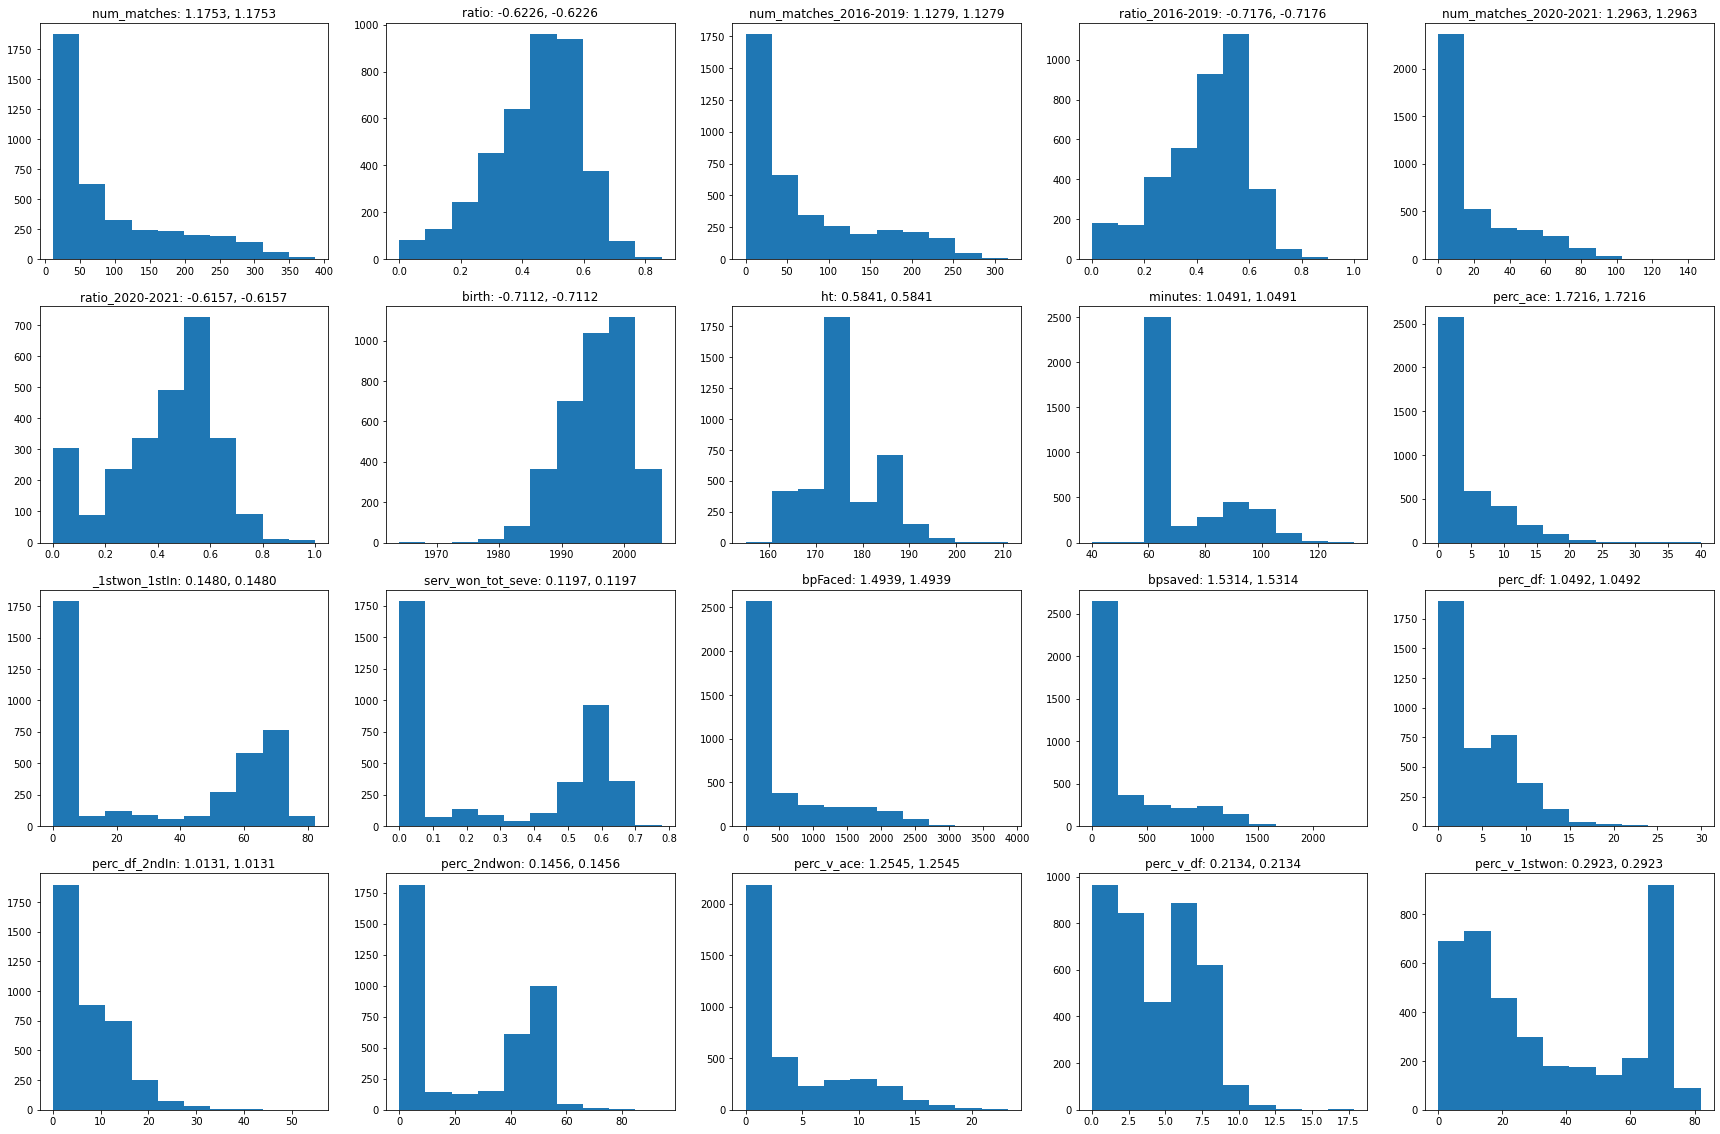

In [33]:
f, axs = plt.subplots(nrows = 4, ncols = 5, figsize=(30,20))

for i in range(len(pl_num.columns)):
    axs[int(i/5)][i%5].hist(pl_num[pl_num.columns[i]])
    axs[int(i/5)][i%5].set_title(pl_num.columns[i] + ": " + '{:.4f}'.format(pl_num[pl_num.columns[i]].skew()) + ", " + '{:.4f}'.format(pl_num[pl_num.columns[i]].skew()))
plt.show()

### categorical attribute

In [34]:
print(pl_cat.gender.unique())

['M' 'F']


In [35]:
print(pl_cat.gender.value_counts())

F    2822
M    1085
Name: gender, dtype: int64


In [36]:
print(pl_cat[pl_cat.gender.isna()])

Empty DataFrame
Columns: [name, hand, gender, ioc]
Index: []


In [37]:
print(pl_cat.hand.value_counts())

R    1876
U    1782
L     249
Name: hand, dtype: int64


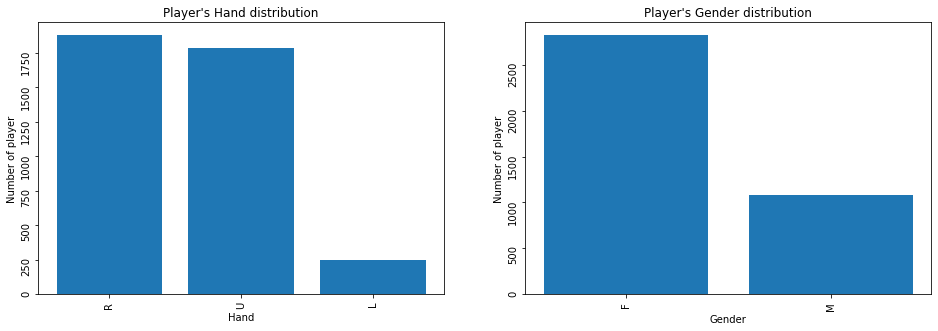

In [38]:
f, axs = plt.subplots(ncols=2, figsize=(16,5))
axs[0].bar(['R','U','L'],pl_cat.hand.value_counts())
axs[0].tick_params(labelrotation=90)
axs[0].set_title("Player's Hand distribution")
axs[0].set_xlabel("Hand")
axs[0].set_ylabel("Number of player")

axs[1].bar(sorted(pl_cat.gender.unique()),pl_cat.gender.value_counts())
axs[1].tick_params(labelrotation=90)
axs[1].set_title("Player's Gender distribution")
axs[1].set_xlabel("Gender")
axs[1].set_ylabel("Number of player")

plt.show() 

<AxesSubplot:title={'center':'Distribution of ioc'}, xlabel='ioc'>

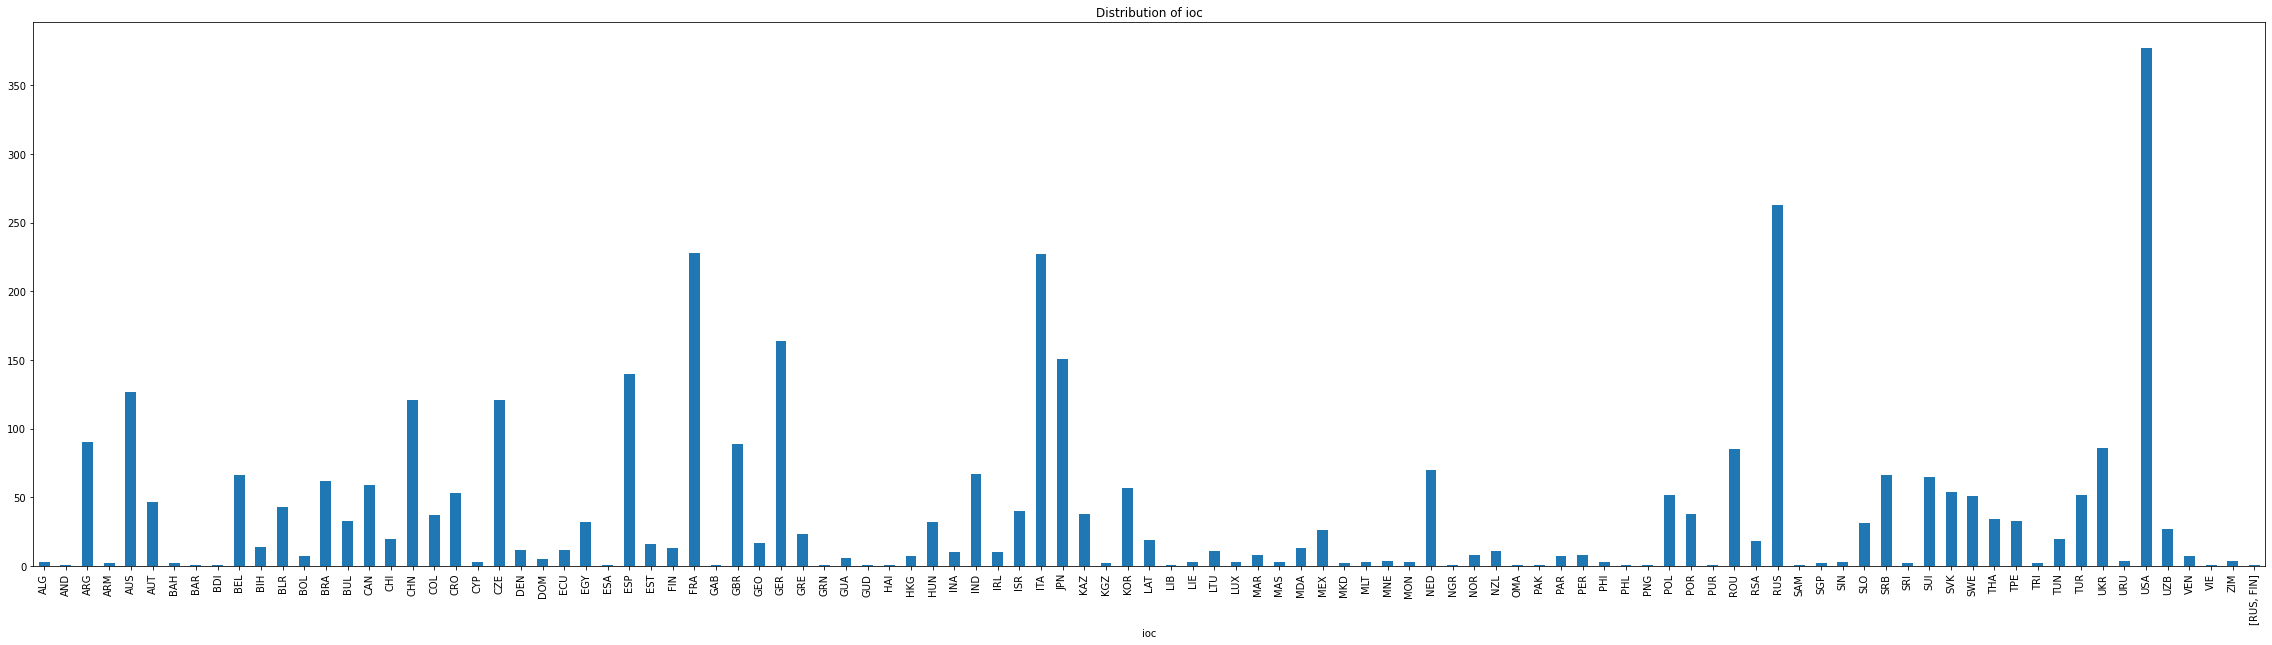

In [39]:
lf = pl_cat.groupby([pl_cat.ioc]).size()
lf.plot(
    figsize=(40, 10), 
    title="Distribution of ioc", 
    kind='bar')

<AxesSubplot:title={'center':'Distribution of ioc'}, xlabel='ioc'>

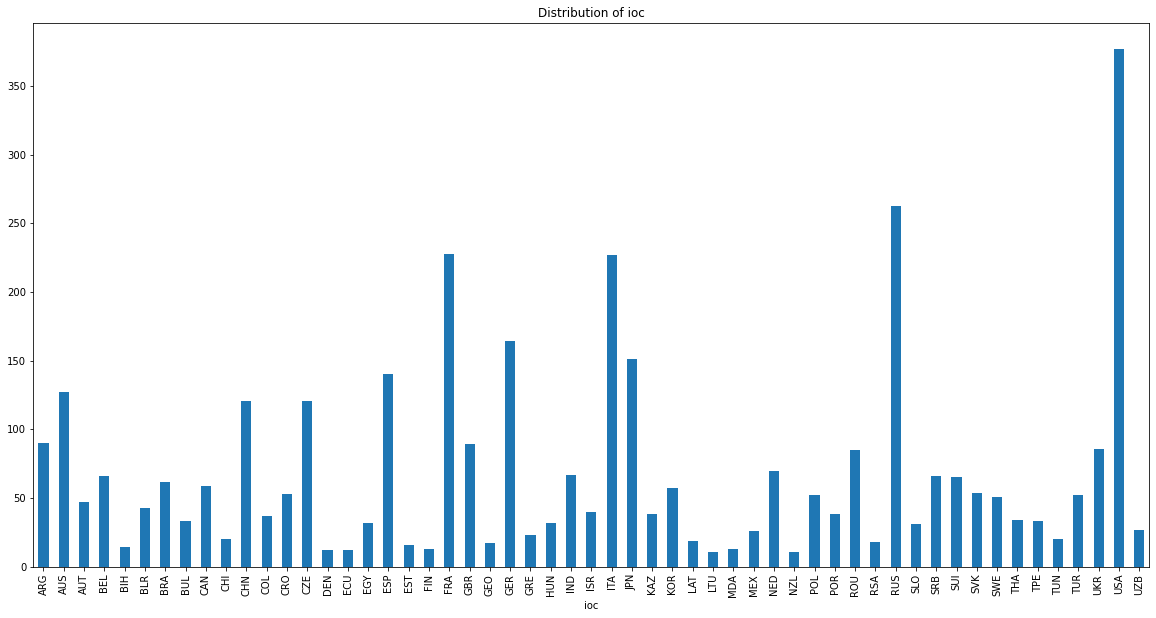

In [40]:
lf = pl_cat.groupby(pl_cat.ioc).size()
lf=lf[lf>10]
lf.plot(
    figsize=(20, 10), 
    title="Distribution of ioc", 
    kind='bar')



## outliers

In [41]:
pl_num.isna().sum()

num_matches                 0
ratio                       0
num_matches_2016-2019       0
ratio_2016-2019           122
num_matches_2020-2021       0
ratio_2020-2021          1278
birth                     221
ht                          0
minutes                     0
perc_ace                    0
_1stwon_1stIn               0
serv_won_tot_seve           0
bpFaced                     0
bpsaved                     0
perc_df                     0
perc_df_2ndIn               0
perc_2ndwon                 0
perc_v_ace                  0
perc_v_df                   0
perc_v_1stwon               0
dtype: int64

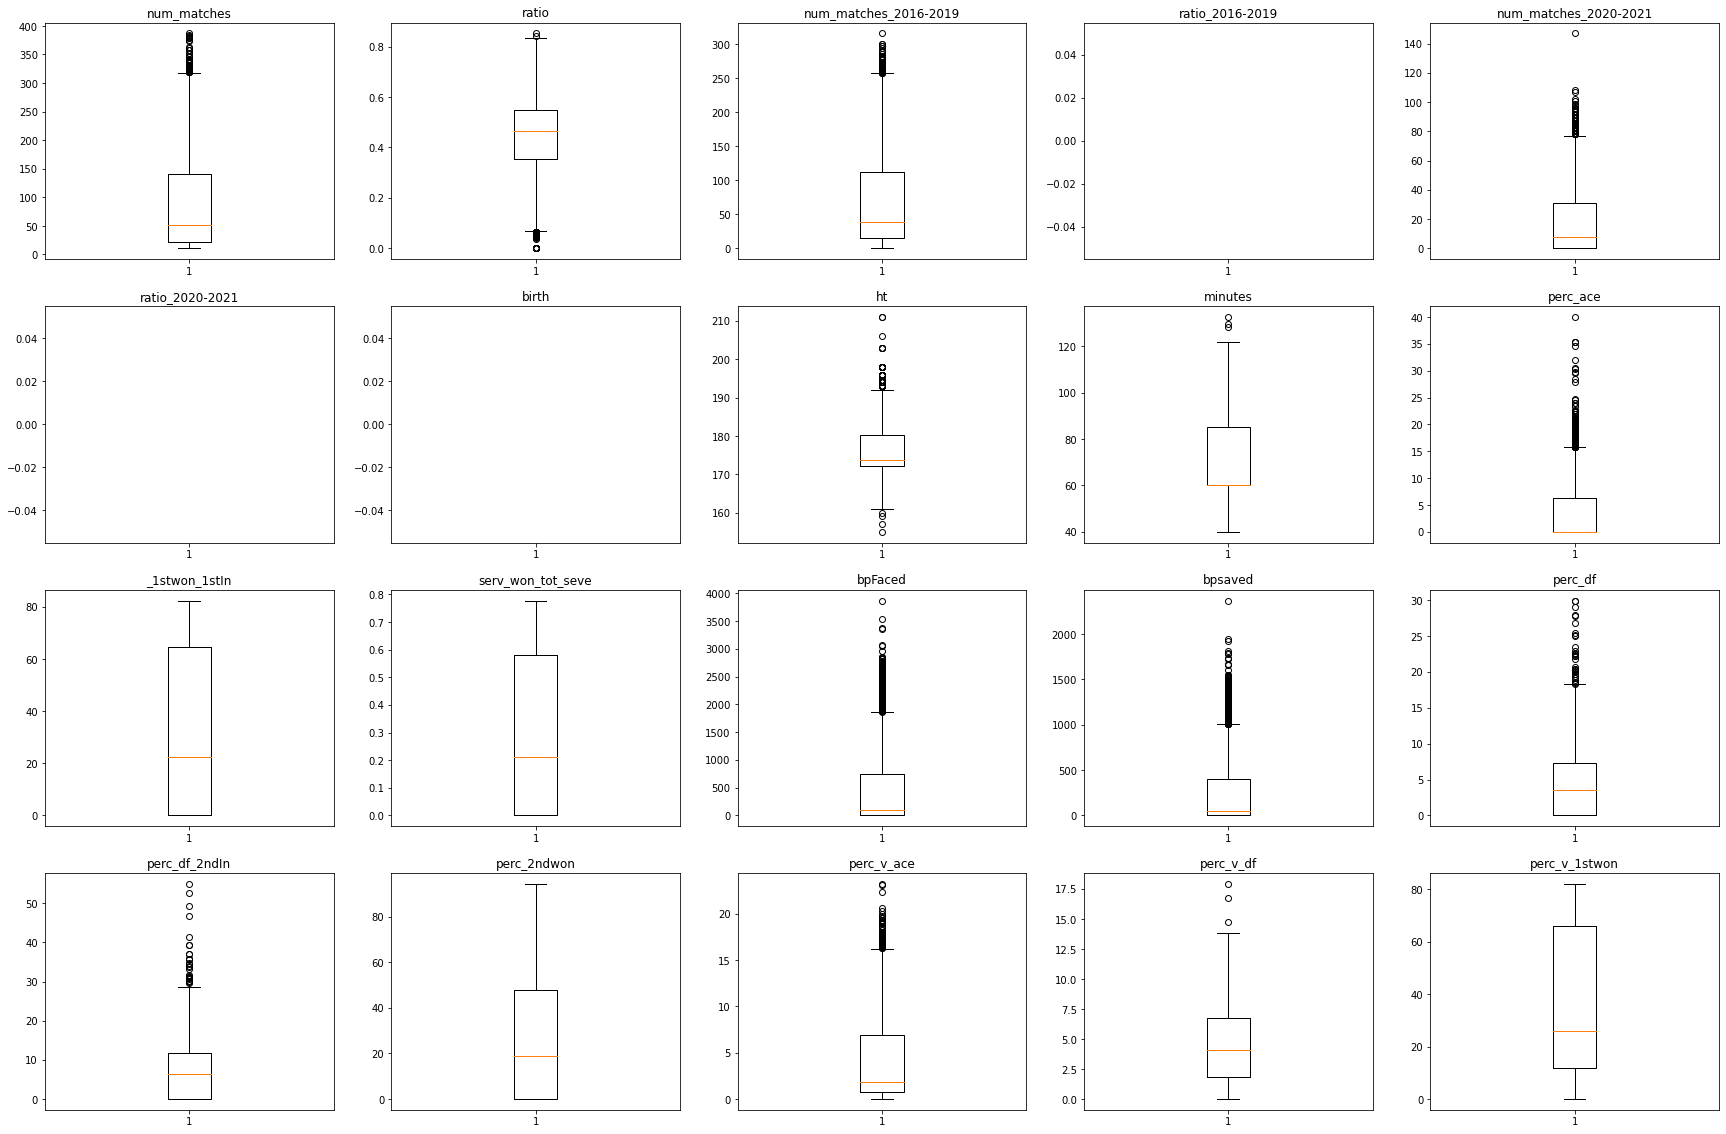

In [42]:
f, axs = plt.subplots(nrows = 4, ncols = 5, figsize=(30,20))

for i in range(len(pl_num.columns)):
    axs[int(i/5)][i%5].boxplot(pl_num[pl_num.columns[i]])
    axs[int(i/5)][i%5].set_title(pl_num.columns[i])
plt.show()


## Missing Values

In [43]:
b_na=pl_num[pl_num.birth.isna()]
print(b_na.describe())

       num_matches       ratio  num_matches_2016-2019  ratio_2016-2019  \
count   221.000000  221.000000             221.000000       130.000000   
mean     17.904977    0.381891               4.556561         0.359459   
std       7.129007    0.159410               5.269355         0.229848   
min      11.000000    0.000000               0.000000         0.000000   
25%      12.000000    0.272727               0.000000         0.200000   
50%      16.000000    0.388889               2.000000         0.400000   
75%      21.000000    0.500000               8.000000         0.532353   
max      61.000000    0.733333              22.000000         0.777778   

       num_matches_2020-2021  ratio_2020-2021  birth          ht     minutes  \
count             221.000000       205.000000    0.0  221.000000  221.000000   
mean               13.348416         0.364730    NaN  172.592584   60.322944   
std                 7.630731         0.168539    NaN    4.269407    3.333995   
min          

In [44]:
b_na=pl_num[(pl_num.perc_ace==0) & (pl_num._1stwon_1stIn==0) & (pl_num.serv_won_tot_seve==0)& (pl_num.bpFaced==0)& (pl_num.bpsaved==0)
           & (pl_num.perc_df==0) & (pl_num.perc_df_2ndIn==0) & (pl_num.perc_2ndwon==0)]
#print(b_na)

In [45]:
player_profile.drop(b_na.index, inplace = True)
pl_num.drop(b_na.index, inplace = True)

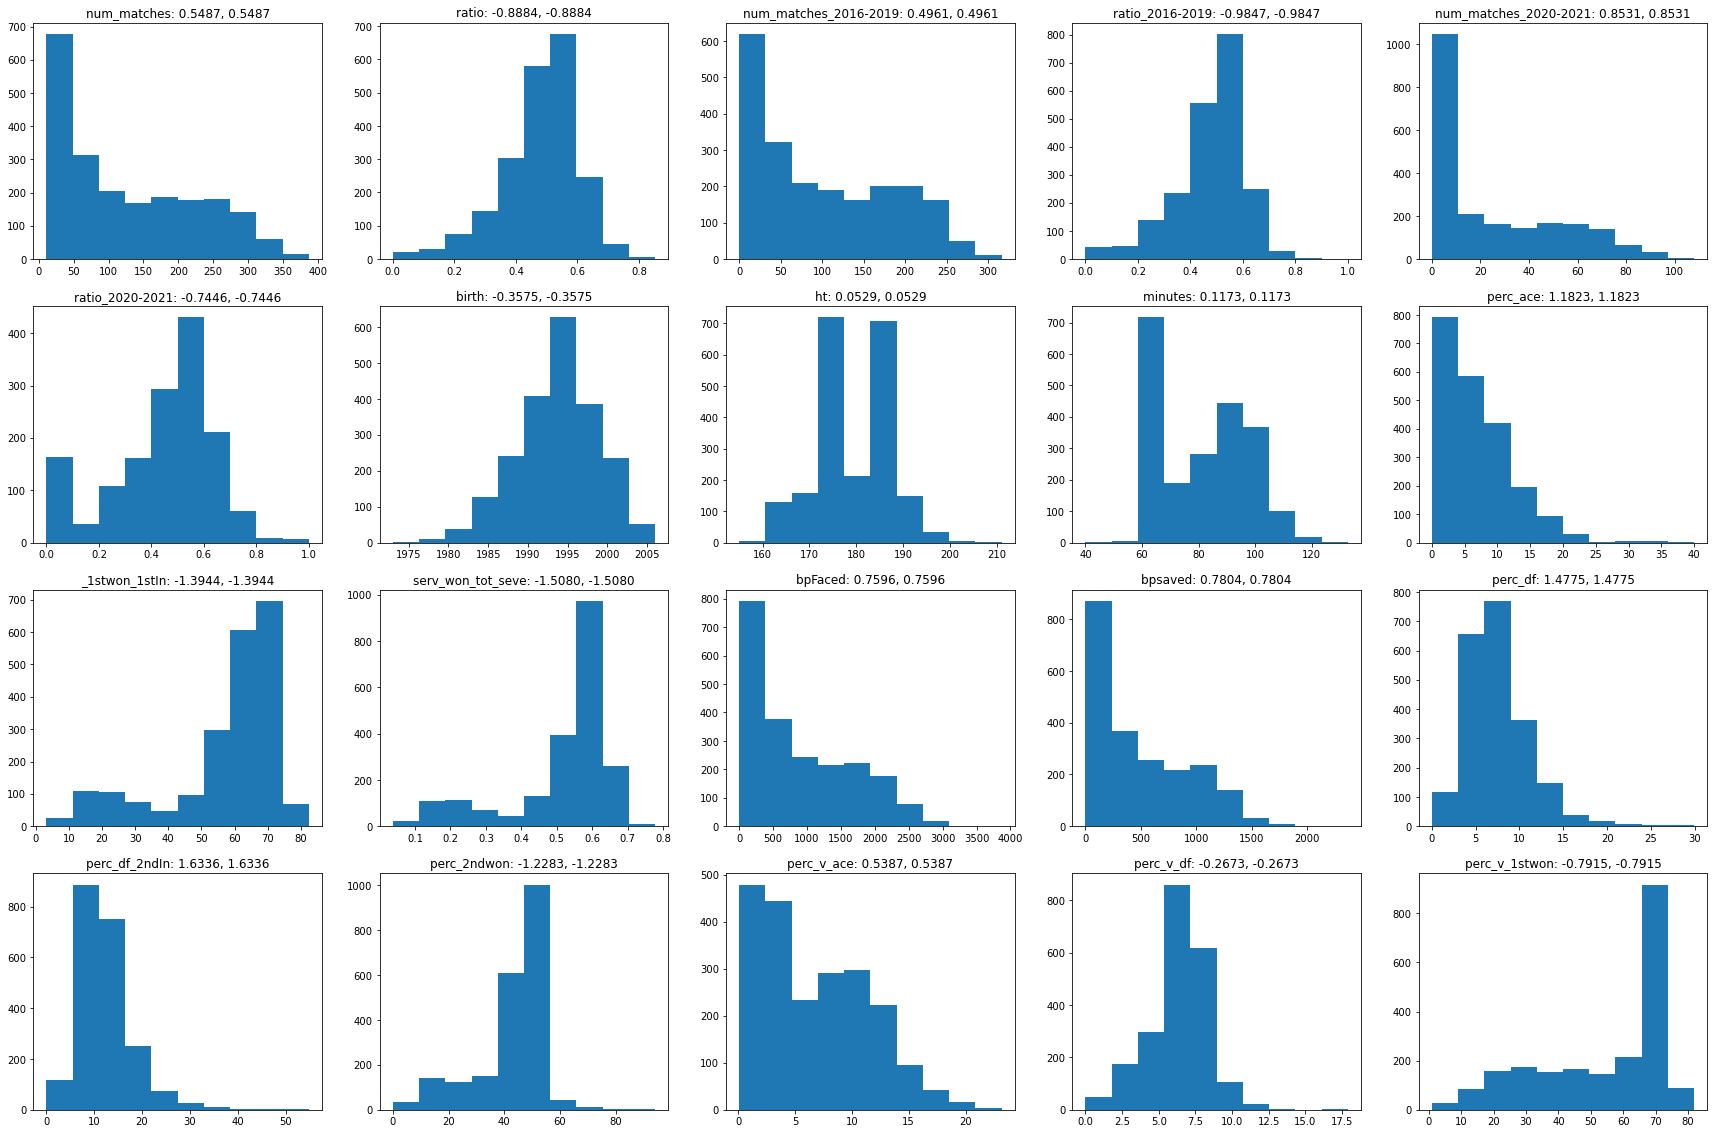

In [46]:
f, axs = plt.subplots(nrows = 4, ncols = 5, figsize=(30,20))

for i in range(len(pl_num.columns)):
    axs[int(i/5)][i%5].hist(pl_num[pl_num.columns[i]])
    axs[int(i/5)][i%5].set_title(pl_num.columns[i] + ": " + '{:.4f}'.format(pl_num[pl_num.columns[i]].skew()) + ", " + '{:.4f}'.format(pl_num[pl_num.columns[i]].skew()))
plt.show()

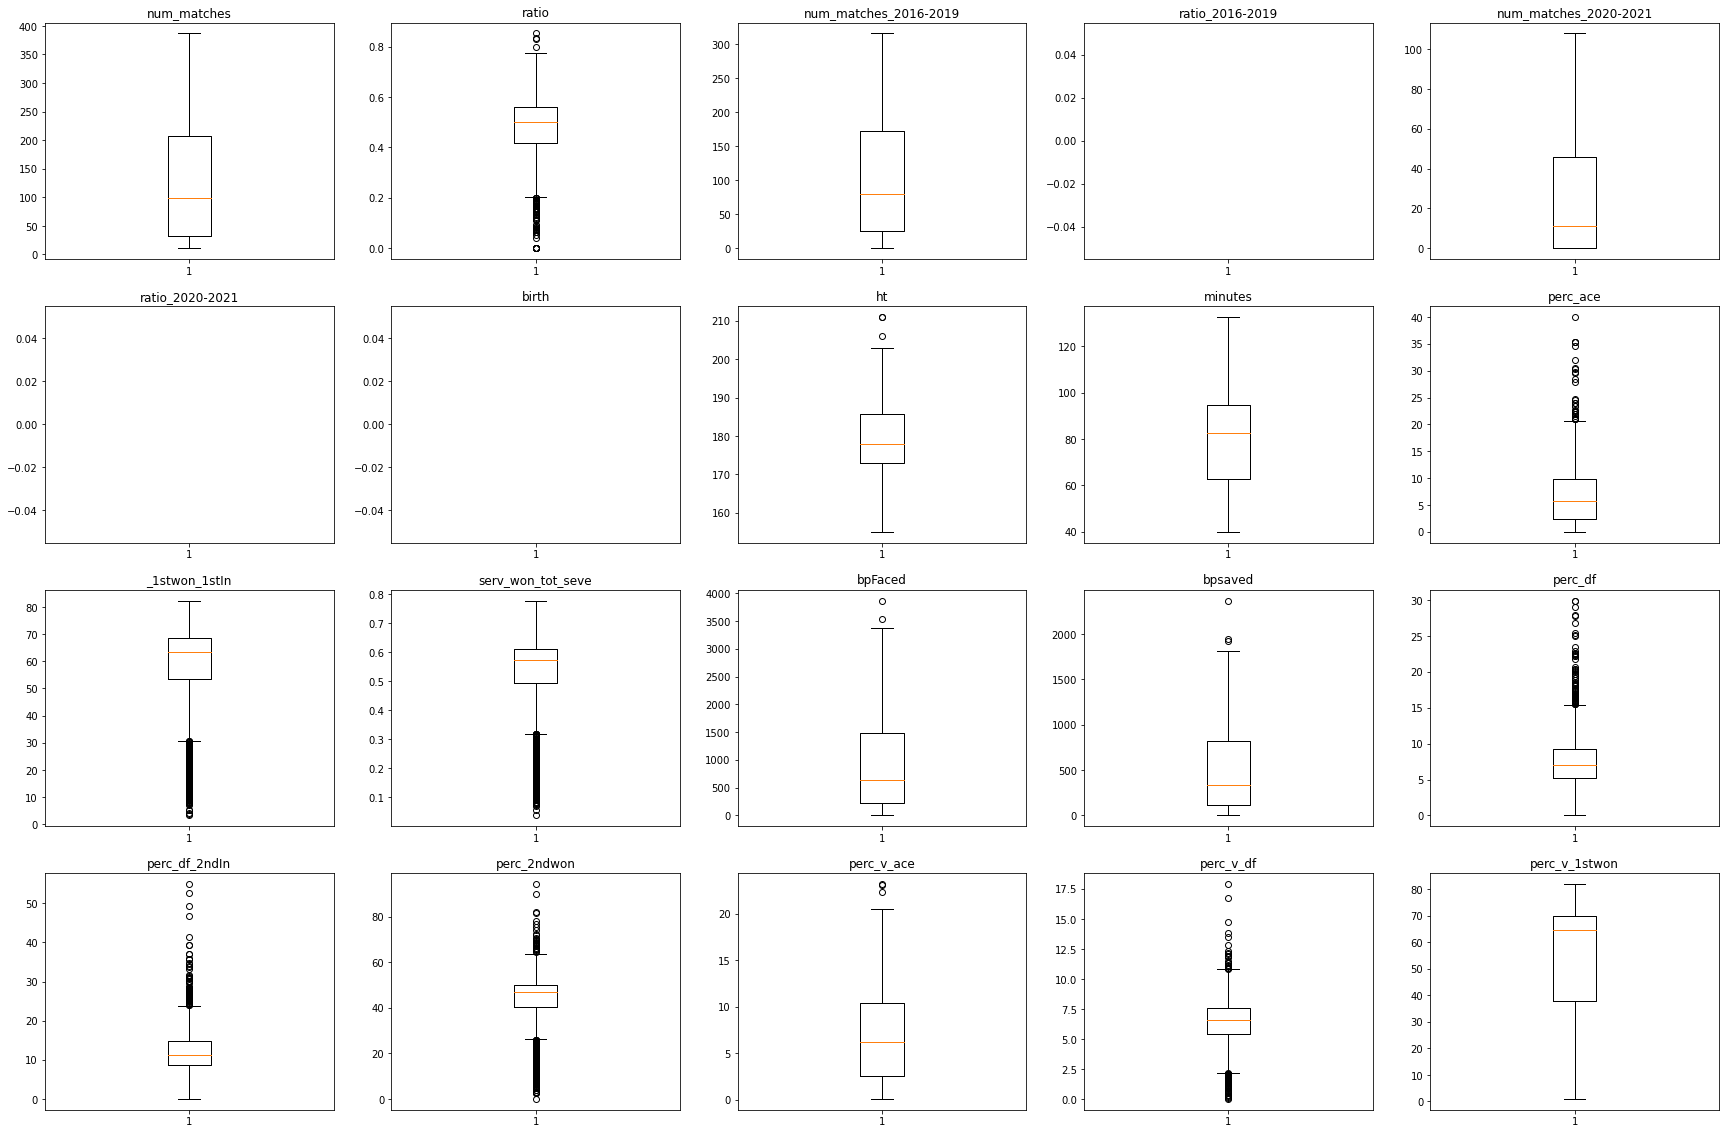

In [47]:
f, axs = plt.subplots(nrows = 4, ncols = 5, figsize=(30,20))

for i in range(len(pl_num.columns)):
    axs[int(i/5)][i%5].boxplot(pl_num[pl_num.columns[i]])
    axs[int(i/5)][i%5].set_title(pl_num.columns[i])
plt.show()


In [48]:
def detecting_outliers(attr):
    q1 = attr.quantile(0.25)
    q3 = attr.quantile(0.75)
    iqr = q3 - q1
    L = q1 - 2*iqr
    R = q3 + 2*iqr
    return L, R

In [49]:
def detecting_outliers_numerical(df, attr, substitute):
    print("BEFORE")
    #df.hist(attr) 
    plt.show()
    df.boxplot(attr) 
    plt.show()
    
    L, R = detecting_outliers(df[attr])
    print("L, R", L, R)
    if L < 0:
        L = 0

    df_outliers = df[(df[attr]< L) | (df[attr] > R)]
    new_df = df.drop(df_outliers.index)

    if substitute == 'median':
        median = df[attr].median()
        print("facciamo la mediana", median)
        df_outliers.loc[(df_outliers[attr] < L), attr] = median 
        df_outliers.loc[(df_outliers[attr] > R), attr] = median
    else:
        df_outliers.loc[(df_outliers[attr] < L), attr] = L
        df_outliers.loc[(df_outliers[attr] > R), attr] = R
    
    print("AFTER")
    new_df.append(df_outliers)
    #new_df[attr].plot.hist()
    plt.show()
    new_df[attr].plot.box()
    plt.show()
    
    return new_df 

In [50]:
L, R = detecting_outliers(pl_num.ratio)
outliers = player_profile[(player_profile.ratio > R) | (player_profile.ratio < L)]
outliers.num_matches.describe()



count     30.000000
mean      27.466667
std       59.178709
min       11.000000
25%       13.000000
50%       16.000000
75%       18.000000
max      339.000000
Name: num_matches, dtype: float64

In [51]:
#because of outlier players have few matches, drop it
player_profile.drop(outliers.index, inplace = True)

In [52]:
L, R = detecting_outliers(pl_num.minutes)
outliers = player_profile[(player_profile.minutes > R) | (player_profile.minutes < L)]
outliers.num_matches.describe()
outliers

,name,num_matches,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,hand,gender,ioc,birth,ht,minutes,perc_ace,_1stwon_1stIn,serv_won_tot_seve,bpFaced,bpsaved,perc_df,perc_df_2ndIn,perc_2ndwon,perc_v_ace,perc_v_df,perc_v_1stwon


In [53]:
player_profile.drop(outliers.index, inplace = True)

In [54]:
pl_num=player_profile
pl_num=pl_num.drop(['name','hand','gender','ioc'],1)
pl_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 3906
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_matches            2097 non-null   int64  
 1   ratio                  2097 non-null   float64
 2   num_matches_2016-2019  2097 non-null   float64
 3   ratio_2016-2019        2078 non-null   float64
 4   num_matches_2020-2021  2097 non-null   float64
 5   ratio_2020-2021        1464 non-null   float64
 6   birth                  2095 non-null   float64
 7   ht                     2097 non-null   float64
 8   minutes                2097 non-null   float64
 9   perc_ace               2097 non-null   float64
 10  _1stwon_1stIn          2097 non-null   float64
 11  serv_won_tot_seve      2097 non-null   float64
 12  bpFaced                2097 non-null   float64
 13  bpsaved                2097 non-null   float64
 14  perc_df                2097 non-null   float64
 15  perc

<ipython-input-54-92600ec43522>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  pl_num=pl_num.drop(['name','hand','gender','ioc'],1)


In [55]:
pl_num.isna().sum()

num_matches                0
ratio                      0
num_matches_2016-2019      0
ratio_2016-2019           19
num_matches_2020-2021      0
ratio_2020-2021          633
birth                      2
ht                         0
minutes                    0
perc_ace                   0
_1stwon_1stIn              0
serv_won_tot_seve          0
bpFaced                    0
bpsaved                    0
perc_df                    0
perc_df_2ndIn              0
perc_2ndwon                0
perc_v_ace                 0
perc_v_df                  0
perc_v_1stwon              0
dtype: int64

In [56]:
player_profile.isna().sum()

name                       0
num_matches                0
ratio                      0
num_matches_2016-2019      0
ratio_2016-2019           19
num_matches_2020-2021      0
ratio_2020-2021          633
hand                       0
gender                     0
ioc                        0
birth                      2
ht                         0
minutes                    0
perc_ace                   0
_1stwon_1stIn              0
serv_won_tot_seve          0
bpFaced                    0
bpsaved                    0
perc_df                    0
perc_df_2ndIn              0
perc_2ndwon                0
perc_v_ace                 0
perc_v_df                  0
perc_v_1stwon              0
dtype: int64

In [57]:
player_profile[player_profile['birth'].isna()]

,name,num_matches,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,hand,gender,ioc,birth,ht,minutes,perc_ace,_1stwon_1stIn,serv_won_tot_seve,bpFaced,bpsaved,perc_df,perc_df_2ndIn,perc_2ndwon,perc_v_ace,perc_v_df,perc_v_1stwon
248,AMARNI BANKS,26,0.461538,3.0,0.333333,23.0,0.478261,R,F,GBR,NaN,177.714286,61.571429,0.00,45.333333,0.386787,84.0,14.0,6.67,11.38,27.32,1.33,1.90,16.25
2935,PAULINA BAKAITE,15,0.133333,15.0,0.133333,0.0,NaN,U,F,LTU,NaN,172.137868,97.307692,3.15,41.079460,0.391993,159.0,88.0,9.15,14.99,36.12,2.83,5.98,54.02


In [58]:
player_profile.loc[player_profile['name']=='AMARNI BANKS', 'birth']=2002
player_profile.loc[player_profile['name']=='PAULINA BAKAITE', 'birth'] =1999

In [59]:
player_profile[player_profile['ht'].isna()]

,name,num_matches,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,hand,gender,ioc,birth,ht,minutes,perc_ace,_1stwon_1stIn,serv_won_tot_seve,bpFaced,bpsaved,perc_df,perc_df_2ndIn,perc_2ndwon,perc_v_ace,perc_v_df,perc_v_1stwon


In [60]:
player_profile.loc[player_profile['name']=='KUAN YI LEE', 'ht'] =178
player_profile.loc[player_profile['name']=='KUAN YI LEE', 'gender'] ='M'

In [61]:
player_profile[player_profile['gender']=='U']

,name,num_matches,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,hand,gender,ioc,birth,ht,minutes,perc_ace,_1stwon_1stIn,serv_won_tot_seve,bpFaced,bpsaved,perc_df,perc_df_2ndIn,perc_2ndwon,perc_v_ace,perc_v_df,perc_v_1stwon


In [62]:
player_profile[player_profile['ratio_2016-2019'].isna()]

,name,num_matches,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,hand,gender,ioc,birth,ht,minutes,perc_ace,_1stwon_1stIn,serv_won_tot_seve,bpFaced,bpsaved,perc_df,perc_df_2ndIn,perc_2ndwon,perc_v_ace,perc_v_df,perc_v_1stwon
137,ALEXANDER SHEVCHENKO,11,0.727273,0.0,NaN,11.0,0.727273,U,M,RUS,2001.0,187.266667,98.312500,9.51,71.979434,0.620104,61.0,35.0,7.71,7.96,51.72,3.96,7.27,58.59
150,ALEXANDRA EALA,33,0.545455,0.0,NaN,33.0,0.545455,U,F,PHL,2005.0,172.137868,64.005556,2.52,46.722561,0.447646,279.0,113.0,20.35,34.68,41.43,2.11,5.75,35.13
517,ARTHUR CAZAUX,27,0.407407,0.0,NaN,27.0,0.407407,R,M,FRA,2002.0,186.961538,99.332386,15.86,70.900901,0.618975,170.0,102.0,3.42,4.41,50.29,7.05,4.95,69.04
573,BARBORA PALICOVA,30,0.566667,0.0,NaN,30.0,0.566667,R,F,CZE,2004.0,175.785714,63.000000,2.06,25.732383,0.299749,143.0,52.0,6.18,10.66,37.30,1.65,2.62,15.51
648,BRIANA SZABO,27,0.592593,0.0,NaN,27.0,0.592593,U,F,ROU,2006.0,173.714286,60.954545,0.00,16.161616,0.149439,99.0,44.0,1.01,1.82,12.75,0.17,1.02,5.16
688,CARLOS GIMENO VALERO,34,0.617647,0.0,NaN,34.0,0.617647,U,M,ESP,2001.0,182.652174,98.225275,2.57,64.350064,0.582322,249.0,142.0,12.74,26.26,45.62,7.12,7.75,62.44
1003,DOMINIC STEPHAN STRICKER,18,0.611111,0.0,NaN,18.0,0.611111,U,M,SUI,2003.0,182.833333,99.870130,22.71,78.502415,0.669286,99.0,63.0,5.19,7.52,50.17,14.30,4.80,73.47
1024,DUJE AJDUKOVIC,54,0.592593,0.0,NaN,54.0,0.592593,R,M,CRO,2001.0,194.000000,105.488636,7.91,66.984258,0.594928,444.0,273.0,5.80,8.11,49.02,5.36,5.81,64.23
2058,KYRIAN JACQUET,26,0.538462,0.0,NaN,26.0,0.538462,R,M,FRA,2001.0,186.961538,93.065476,7.58,66.190901,0.596386,188.0,97.0,7.23,11.49,49.22,7.04,6.45,66.08
2200,LUCA NARDI,20,0.250000,0.0,NaN,20.0,0.250000,R,M,ITA,2003.0,185.705882,83.100000,6.24,68.253968,0.612159,124.0,71.0,6.01,9.65,49.91,10.48,5.70,72.29


In [63]:
player_profile['ratio_2016-2019'].describe()

count    2078.000000
mean        0.481449
std         0.126333
min         0.000000
25%         0.416667
50%         0.500000
75%         0.564844
max         1.000000
Name: ratio_2016-2019, dtype: float64

In [64]:
player_profile['ratio_2016-2019'].fillna(0.0, inplace=True)

In [65]:
player_profile['ratio_2016-2019'].describe()

count    2097.000000
mean        0.477087
std         0.133781
min         0.000000
25%         0.413793
50%         0.500000
75%         0.564103
max         1.000000
Name: ratio_2016-2019, dtype: float64

In [66]:
player_profile['ratio_2020-2021'].describe()

count    1464.000000
mean        0.442183
std         0.202636
min         0.000000
25%         0.343750
50%         0.489362
75%         0.580346
max         1.000000
Name: ratio_2020-2021, dtype: float64

In [67]:
player_profile['ratio_2020-2021'].fillna(0.0, inplace=True)

In [68]:
player_profile['ratio_2020-2021'].describe()

count    2097.000000
mean        0.308706
std         0.264359
min         0.000000
25%         0.000000
50%         0.375000
75%         0.533333
max         1.000000
Name: ratio_2020-2021, dtype: float64

### CORRELATION

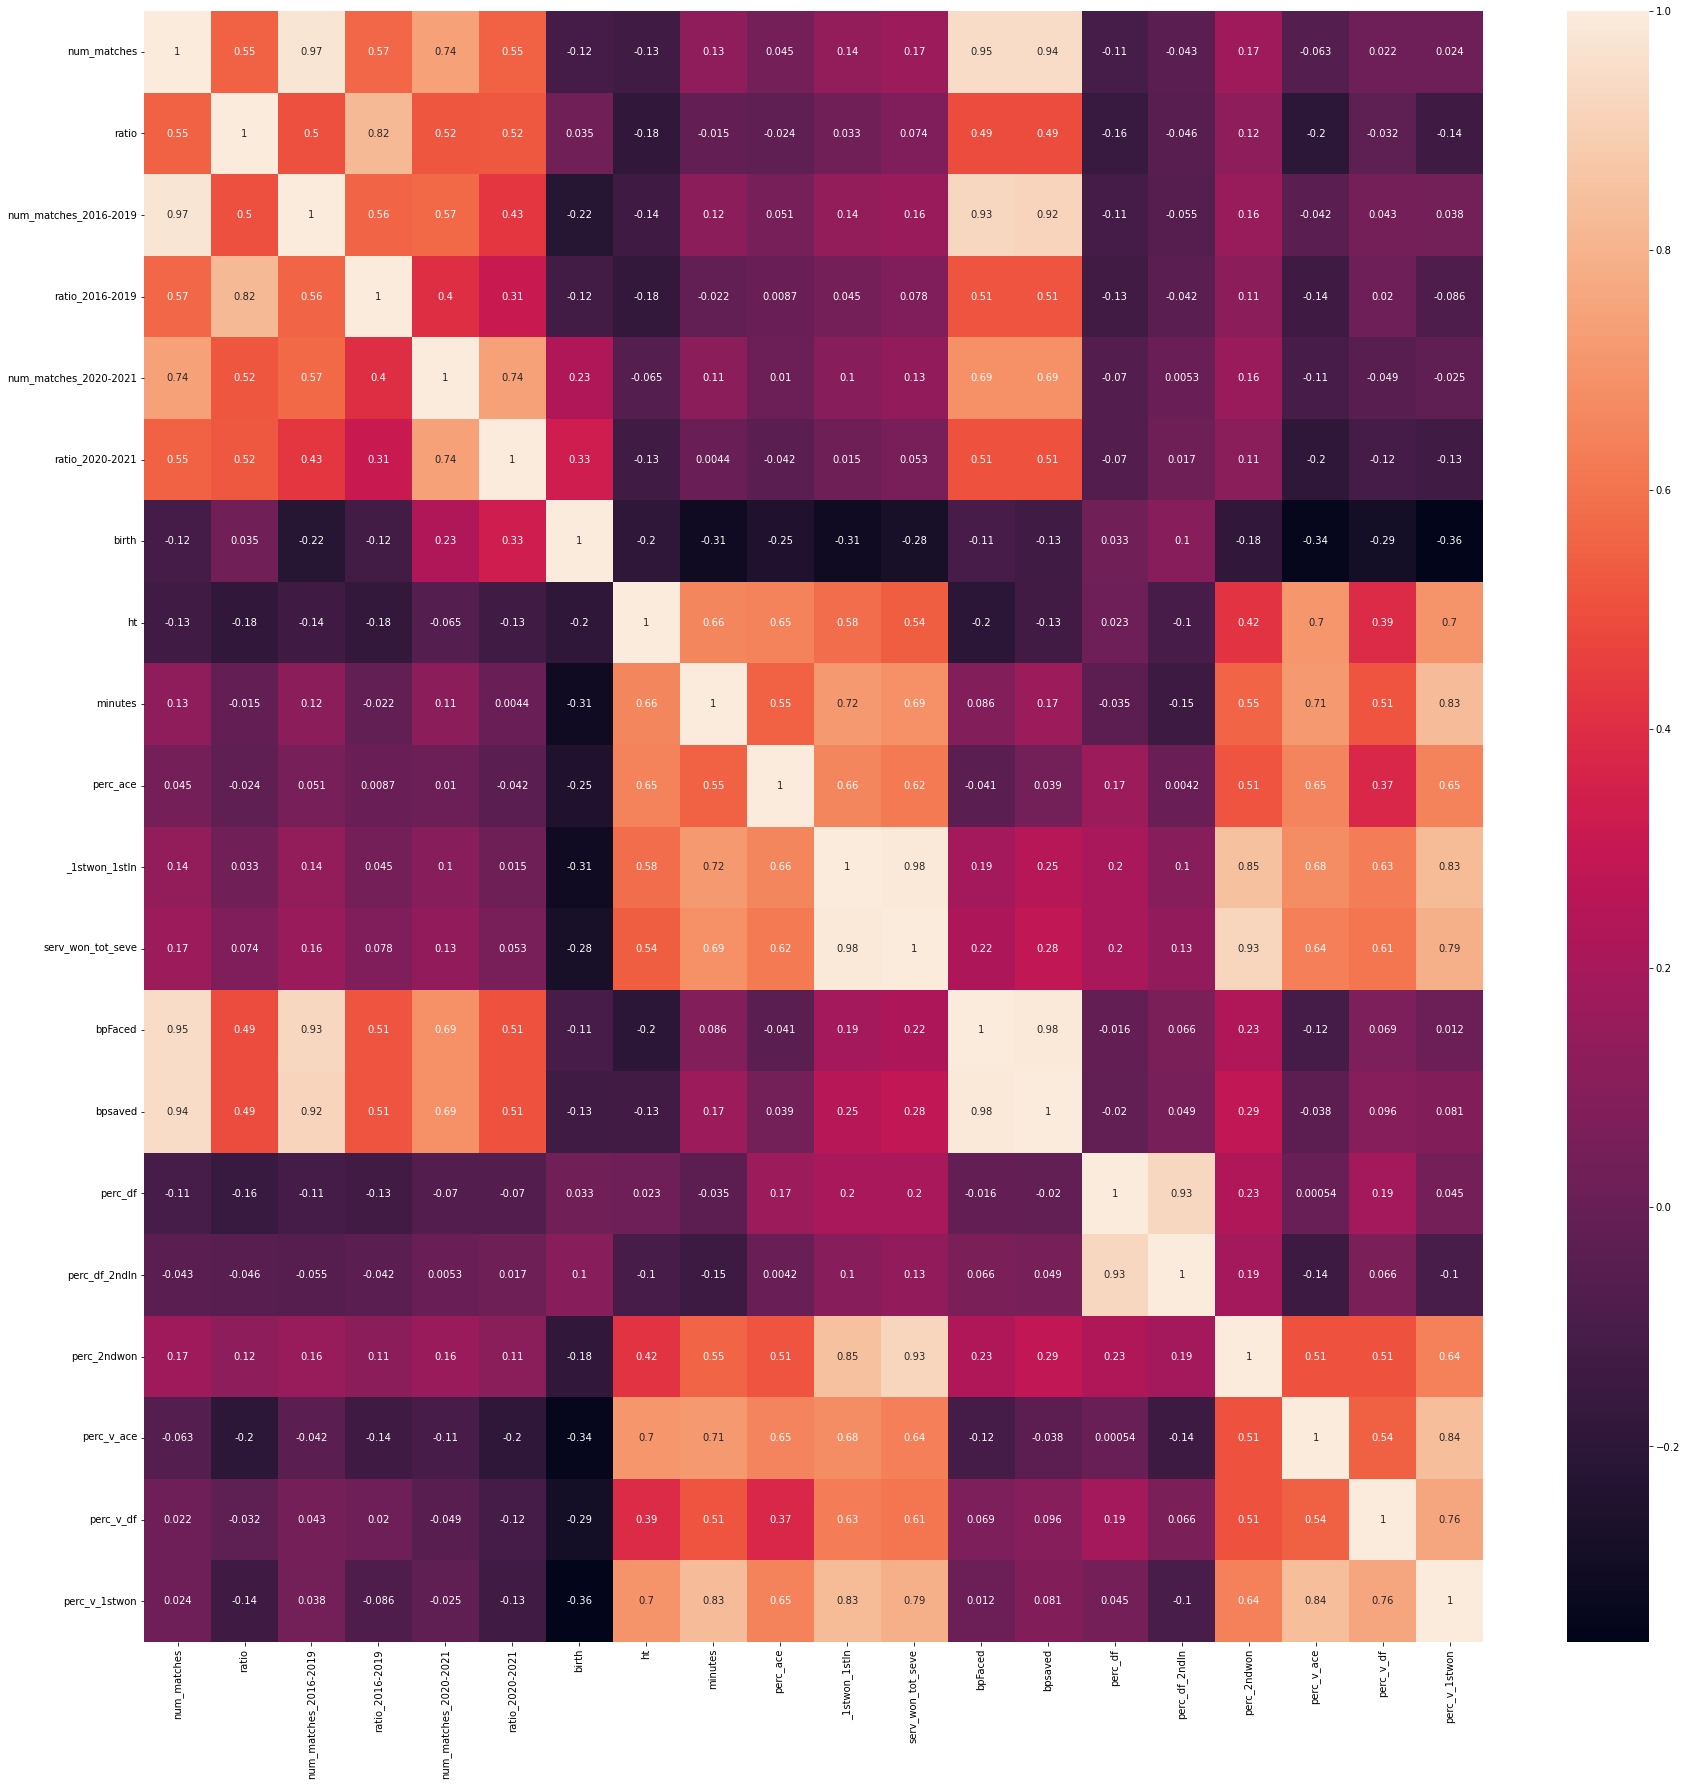

In [69]:
p = player_profile
#p = p.replace({0:np.nan})
matrix = p.corr()
fig, ax = plt.subplots(figsize=(30, 30)) #Sample figsize in inches
sn.heatmap(matrix, annot=True)
plt.show()

In [70]:
def scatter_subplots(cell, x, y, x_label, y_label):
    cell.scatter(x, y)
    cell.set_title('Corr(' + x_label + ',' + y_label +'): ' + str(x.corr(y)))
    cell.set_xlabel(x_label)
    cell.set_ylabel(y_label)



### scatter with correlation >0.90

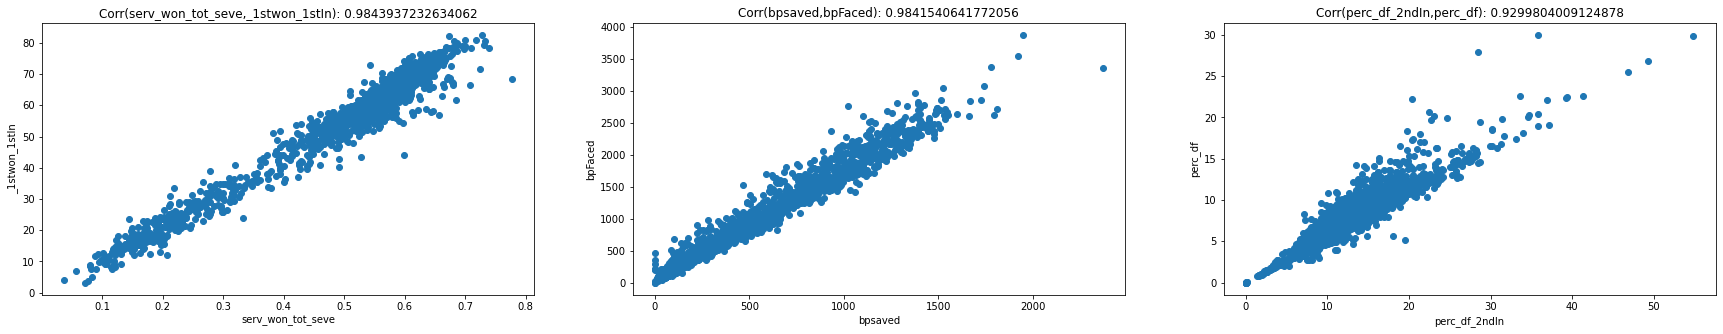

In [71]:
f, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(30,5))
scatter_subplots(axs[0], p.serv_won_tot_seve, p._1stwon_1stIn, 'serv_won_tot_seve', '_1stwon_1stIn')
scatter_subplots(axs[1], p.bpsaved, p.bpFaced, 'bpsaved', 'bpFaced')
scatter_subplots(axs[2], p.perc_df_2ndIn, p.perc_df, 'perc_df_2ndIn', 'perc_df')
plt.show()

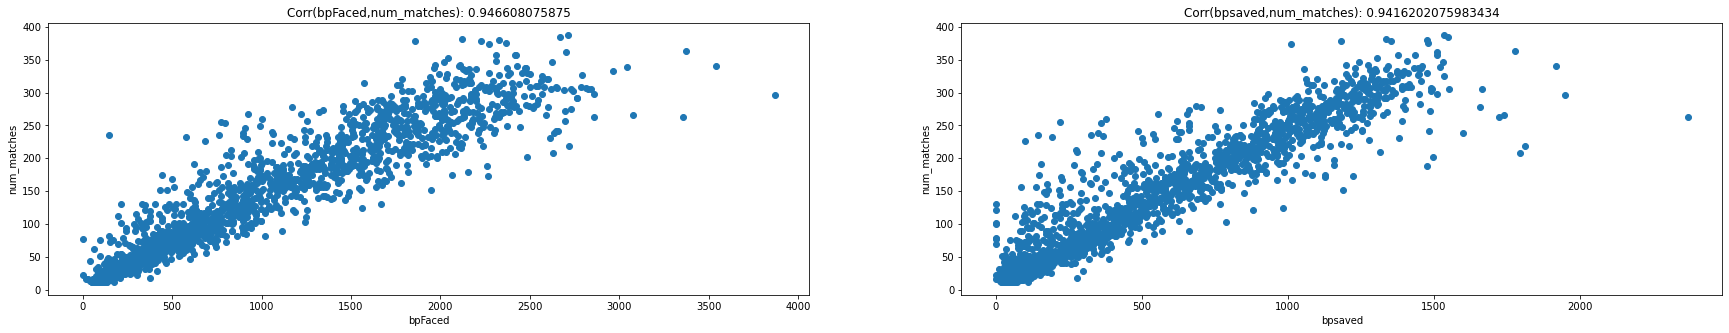

In [72]:
f, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(30,5))
scatter_subplots(axs[0], p['bpFaced'], p.num_matches, 'bpFaced', 'num_matches')
scatter_subplots(axs[1], p['bpsaved'], p.num_matches, 'bpsaved', 'num_matches')

### scatter with correlation >0.80

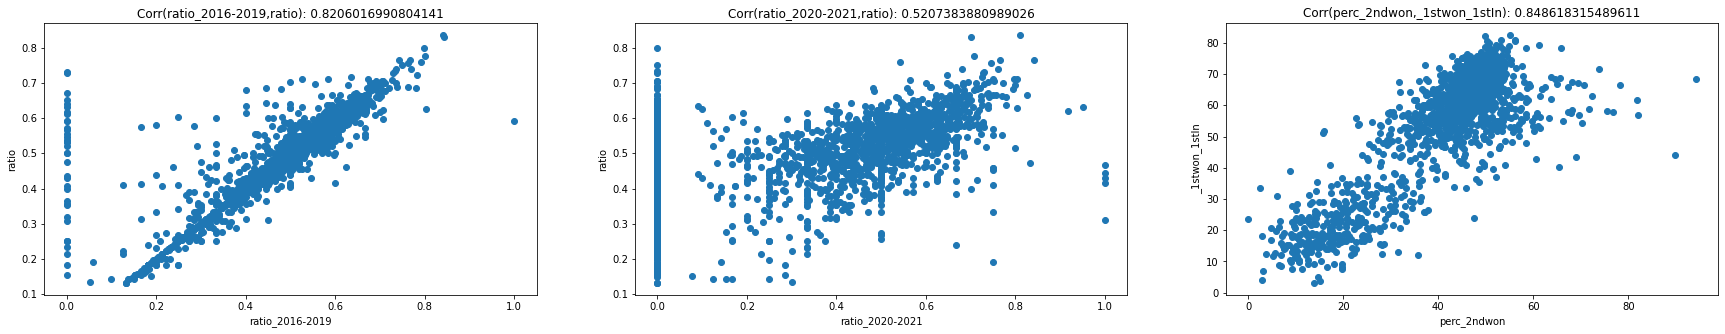

In [73]:
f, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(30,5))
scatter_subplots(axs[0], p['ratio_2016-2019'], p.ratio, 'ratio_2016-2019', 'ratio')
scatter_subplots(axs[1], p['ratio_2020-2021'], p.ratio, 'ratio_2020-2021', 'ratio')
scatter_subplots(axs[2], p.perc_2ndwon, p._1stwon_1stIn, 'perc_2ndwon', '_1stwon_1stIn')
plt.show()

## drop colums and save new csv

In [74]:
p.drop(columns=['num_matches','perc_df_2ndIn', 'bpsaved', '_1stwon_1stIn'], inplace=True)

In [75]:
p

,name,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,hand,gender,ioc,birth,ht,minutes,perc_ace,serv_won_tot_seve,bpFaced,perc_df,perc_2ndwon,perc_v_ace,perc_v_df,perc_v_1stwon
0,AARON ADDISON,0.181818,10.0,0.200000,1.0,0.000000,R,M,AUS,1996.0,187.076923,86.694444,14.98,0.587855,83.0,12.32,47.78,8.82,5.88,75.79
1,ABBIE MYERS,0.477707,142.0,0.478873,15.0,0.466667,R,F,AUS,1994.0,170.857143,61.621951,1.30,0.270003,819.0,4.67,22.10,3.18,5.39,37.90
2,ABHINAV SANJEEV SHANMUGAM,0.500000,13.0,0.461538,3.0,0.666667,U,M,IND,1998.0,183.800000,86.875000,20.59,0.613701,111.0,10.89,51.65,7.12,10.10,70.86
4,ABIGAIL TERE APISAH,0.587302,113.0,0.575221,13.0,0.692308,U,F,PNG,1992.0,172.137868,63.205561,3.32,0.565383,1081.0,11.42,54.16,3.76,7.94,47.32
5,ABIR EL FAHIMI,0.214286,14.0,0.214286,0.0,0.000000,U,F,MAR,1995.0,172.137868,49.409091,0.00,0.189542,110.0,16.30,17.20,0.51,2.55,11.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3892,ZIZOU BERGS,0.628205,36.0,0.500000,42.0,0.738095,R,M,BEL,1999.0,173.666667,96.377199,9.43,0.635460,480.0,4.39,51.35,5.99,7.03,68.12
3897,ZOE HIVES,0.576271,118.0,0.576271,0.0,0.000000,U,F,AUS,1996.0,170.857143,66.047353,4.00,0.578907,1186.0,7.00,60.39,3.67,8.14,51.36
3899,ZOE KRUGER,0.447368,57.0,0.385965,19.0,0.631579,U,F,RSA,2002.0,172.137868,61.131653,2.33,0.477164,717.0,7.81,44.11,1.91,3.95,27.01
3905,ZSOMBOR PIROS,0.546512,83.0,0.542169,3.0,0.666667,R,M,HUN,1999.0,184.000000,101.407801,7.13,0.584936,678.0,5.84,49.38,8.47,7.21,66.69


In [76]:
player_profile=p
player_profile.to_csv('dataset/tennis_players.csv')


In [77]:
player_profile.to_csv('../Task2/dataset/tennis_players.csv')
player_profile.to_csv('../Task3/dataset/tennis_players.csv')